# Pre-Experiment Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower, GofChisquarePower
from scipy.stats import chi2_contingency, ttest_ind
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Read in the Data
df_demo = pd.read_csv('df_final_demo.txt')
df_demo.columns = df_demo.columns.str.lower()

df_experiment_clients = pd.read_csv('df_final_experiment_clients.txt')
df_experiment_clients.columns = df_experiment_clients.columns.str.lower()

df_web_data_pt_1 = pd.read_csv('df_final_web_data_pt_1.txt')
df_web_data_pt_1.columns = df_web_data_pt_1.columns.str.lower()

df_web_data_pt_2 = pd.read_csv('df_final_web_data_pt_2.txt')
df_web_data_pt_2.columns = df_web_data_pt_2.columns.str.lower()

# Combine the web data parts
df_web_data = pd.concat([df_web_data_pt_1, df_web_data_pt_2])

# Display the first few rows of each dataset to understand their structure
df_demo.head(), df_experiment_clients.head(), df_web_data.head()

/Users/User/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


(   client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
 0     836976             6.0              73.0      60.5     U        2.0   
 1    2304905             7.0              94.0      58.0     U        2.0   
 2    1439522             5.0              64.0      32.0     U        2.0   
 3    1562045            16.0             198.0      49.0     M        2.0   
 4    5126305            12.0             145.0      33.0     F        2.0   
 
          bal  calls_6_mnth  logons_6_mnth  
 0   45105.30           6.0            9.0  
 1  110860.30           6.0            9.0  
 2   52467.79           6.0            9.0  
 3   67454.65           3.0            6.0  
 4  103671.75           0.0            3.0  ,
    client_id variation
 0    9988021      Test
 1    8320017      Test
 2    4033851   Control
 3    1982004      Test
 4    9294070   Control,
    client_id            visitor_id                      visit_id process_step  \
 0    9988021  580560515_7732621

In [2]:
# Calculate the number of unique clients in the data
total_unique_clients = df_web_data['client_id'].nunique()

# Calculate the number of unique clients involved in the experiment
clients_in_experiment = df_experiment_clients[df_experiment_clients['variation'] != 'None']['client_id'].nunique()

print(f"Total number of unique clients: {total_unique_clients}")
print(f"Number of unique clients marked for the experiment: {clients_in_experiment}")

Total number of unique clients: 120157
Number of unique clients marked for the experiment: 70609


# Data Prep

In [3]:
df_web_data = df_web_data.merge(df_experiment_clients, on='client_id', how='left')

# Verify the columns after merging
df_web_data.columns.tolist()

['client_id',
 'visitor_id',
 'visit_id',
 'process_step',
 'date_time',
 'variation']

In [4]:
# Check for duplicate rows based on all columns
duplicates_all = df_web_data[df_web_data.duplicated()]

# Count the number of duplicate rows based on all columns
num_duplicates_all = duplicates_all.shape[0]
print(f"Number of duplicate rows based on all columns: {num_duplicates_all}")

Number of duplicate rows based on all columns: 10764


In [5]:
# Remove duplicate rows based on specific columns
df_web_data_cleaned = df_web_data.drop_duplicates(subset=['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time', 'variation'])

# Verify the removal of duplicates
num_duplicates_after_removal = df_web_data_cleaned[df_web_data_cleaned.duplicated(subset=['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time', 'variation'])].shape[0]
print(f"Number of duplicate rows after removal: {num_duplicates_after_removal}")

# Verify the cleaned dataset
print("Cleaned dataset:")
print(df_web_data_cleaned.head())

df_web_data = df_web_data_cleaned

Number of duplicate rows after removal: 0
Cleaned dataset:
   client_id            visitor_id                      visit_id process_step  \
0    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   
1    9988021  580560515_7732621733  781255054_21935453173_531117       step_2   
2    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   
3    9988021  580560515_7732621733  781255054_21935453173_531117       step_2   
4    9988021  580560515_7732621733  781255054_21935453173_531117       step_3   

             date_time variation  
0  2017-04-17 15:27:07      Test  
1  2017-04-17 15:26:51      Test  
2  2017-04-17 15:19:22      Test  
3  2017-04-17 15:19:13      Test  
4  2017-04-17 15:18:04      Test  


In [6]:
# Merge df_demo with df_final_experiment_clients
df_demo_experiment = pd.merge(df_demo, df_experiment_clients, on='client_id', how='inner')

# Merge the combined dataset with df_final_web_data
df_full = pd.merge(df_demo_experiment, df_web_data, on='client_id', how='inner')

# First, check the unique values in both variation columns to ensure they match
df_full['variation_x'].unique(), df_full['variation_y'].unique()

# Choose one variation column and drop the other
df_full['variation'] = df_full['variation_x']  # or df_full['variation_y'], based on consistency
df_full = df_full.drop(columns=['variation_x', 'variation_y'])

# Verify the updated columns
df_full.columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'visitor_id',
       'visit_id', 'process_step', 'date_time', 'variation'],
      dtype='object')

In [7]:
# Check for duplicate rows based on all columns
duplicates_all = df_full[df_full.duplicated()]

# Count the number of duplicate rows based on all columns
num_duplicates_all = duplicates_all.shape[0]
print(f"Number of duplicate rows based on all columns: {num_duplicates_all}")

Number of duplicate rows based on all columns: 0


In [8]:
# Check for duplicate rows based on all columns
duplicates_all = df_full[df_full.duplicated()]

# Count the number of duplicate rows
num_duplicates_all = duplicates_all.shape[0]

print(f"Number of duplicate rows based on all columns: {num_duplicates_all}")

# Display the duplicate rows
duplicates_all.head()

Number of duplicate rows based on all columns: 0


,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,visitor_id,visit_id,process_step,date_time,variation


In [9]:
# Remove duplicate rows based on specific columns
df_full_cleaned = df_full.drop_duplicates(subset=['client_id', 'process_step', 'date_time'])

# Verify the removal of duplicates
num_duplicates_after_removal = df_full_cleaned[df_full_cleaned.duplicated(subset=['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'visitor_id',
       'visit_id', 'process_step', 'date_time', 'variation'])].shape[0]
print(f"Number of duplicate rows after removal: {num_duplicates_after_removal}")

# Display the cleaned dataset
print("Cleaned dataset:")
print(df_full_cleaned.head())

df_full = df_full_cleaned

Number of duplicate rows after removal: 0
Cleaned dataset:
   client_id  clnt_tenure_yr  clnt_tenure_mnth  clnt_age gendr  num_accts  \
0     836976             6.0              73.0      60.5     U        2.0   
1     836976             6.0              73.0      60.5     U        2.0   
2     836976             6.0              73.0      60.5     U        2.0   
3     836976             6.0              73.0      60.5     U        2.0   
4     836976             6.0              73.0      60.5     U        2.0   

       bal  calls_6_mnth  logons_6_mnth            visitor_id  \
0  45105.3           6.0            9.0  427070339_1413275162   
1  45105.3           6.0            9.0  427070339_1413275162   
2  45105.3           6.0            9.0  427070339_1413275162   
3  45105.3           6.0            9.0  427070339_1413275162   
4  45105.3           6.0            9.0  427070339_1413275162   

                      visit_id process_step            date_time variation  
0  2289767

# Who currently engages Vanguard via this process?:

In [10]:
# Merge again to ensure the 'Variation' column is included
df_demo_with_exp = df_demo.merge(df_experiment_clients, on='client_id', how='left')

# Verify the columns after merging
df_demo_with_exp.columns.tolist()

['client_id',
 'clnt_tenure_yr',
 'clnt_tenure_mnth',
 'clnt_age',
 'gendr',
 'num_accts',
 'bal',
 'calls_6_mnth',
 'logons_6_mnth',
 'variation']

In [11]:
# Get the list of client_ids from the filtered web data
client_ids_in_period = df_web_data['client_id'].unique()

# Filter the demographic data to include only those client_ids
df_demo_unfiltered = df_demo[df_demo['client_id'].isin(client_ids_in_period)]

# Group by variation and calculate summary statistics
demographic_summary_unfiltered = df_demo_unfiltered.agg({
    'clnt_age': ['mean', 'std'],
    'clnt_tenure_yr': ['mean', 'std'],
    'num_accts': ['mean', 'std'],
    'bal': ['mean', 'std'],
    'calls_6_mnth': ['mean', 'std'],
    'logons_6_mnth': ['mean', 'std']
}).reset_index()

demographic_summary_unfiltered

,index,clnt_age,clnt_tenure_yr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,mean,46.442240,12.052950,2.255528,147445.240641,3.382478,5.566740
1,std,15.591273,6.871819,0.534997,301508.706531,2.236580,2.353286


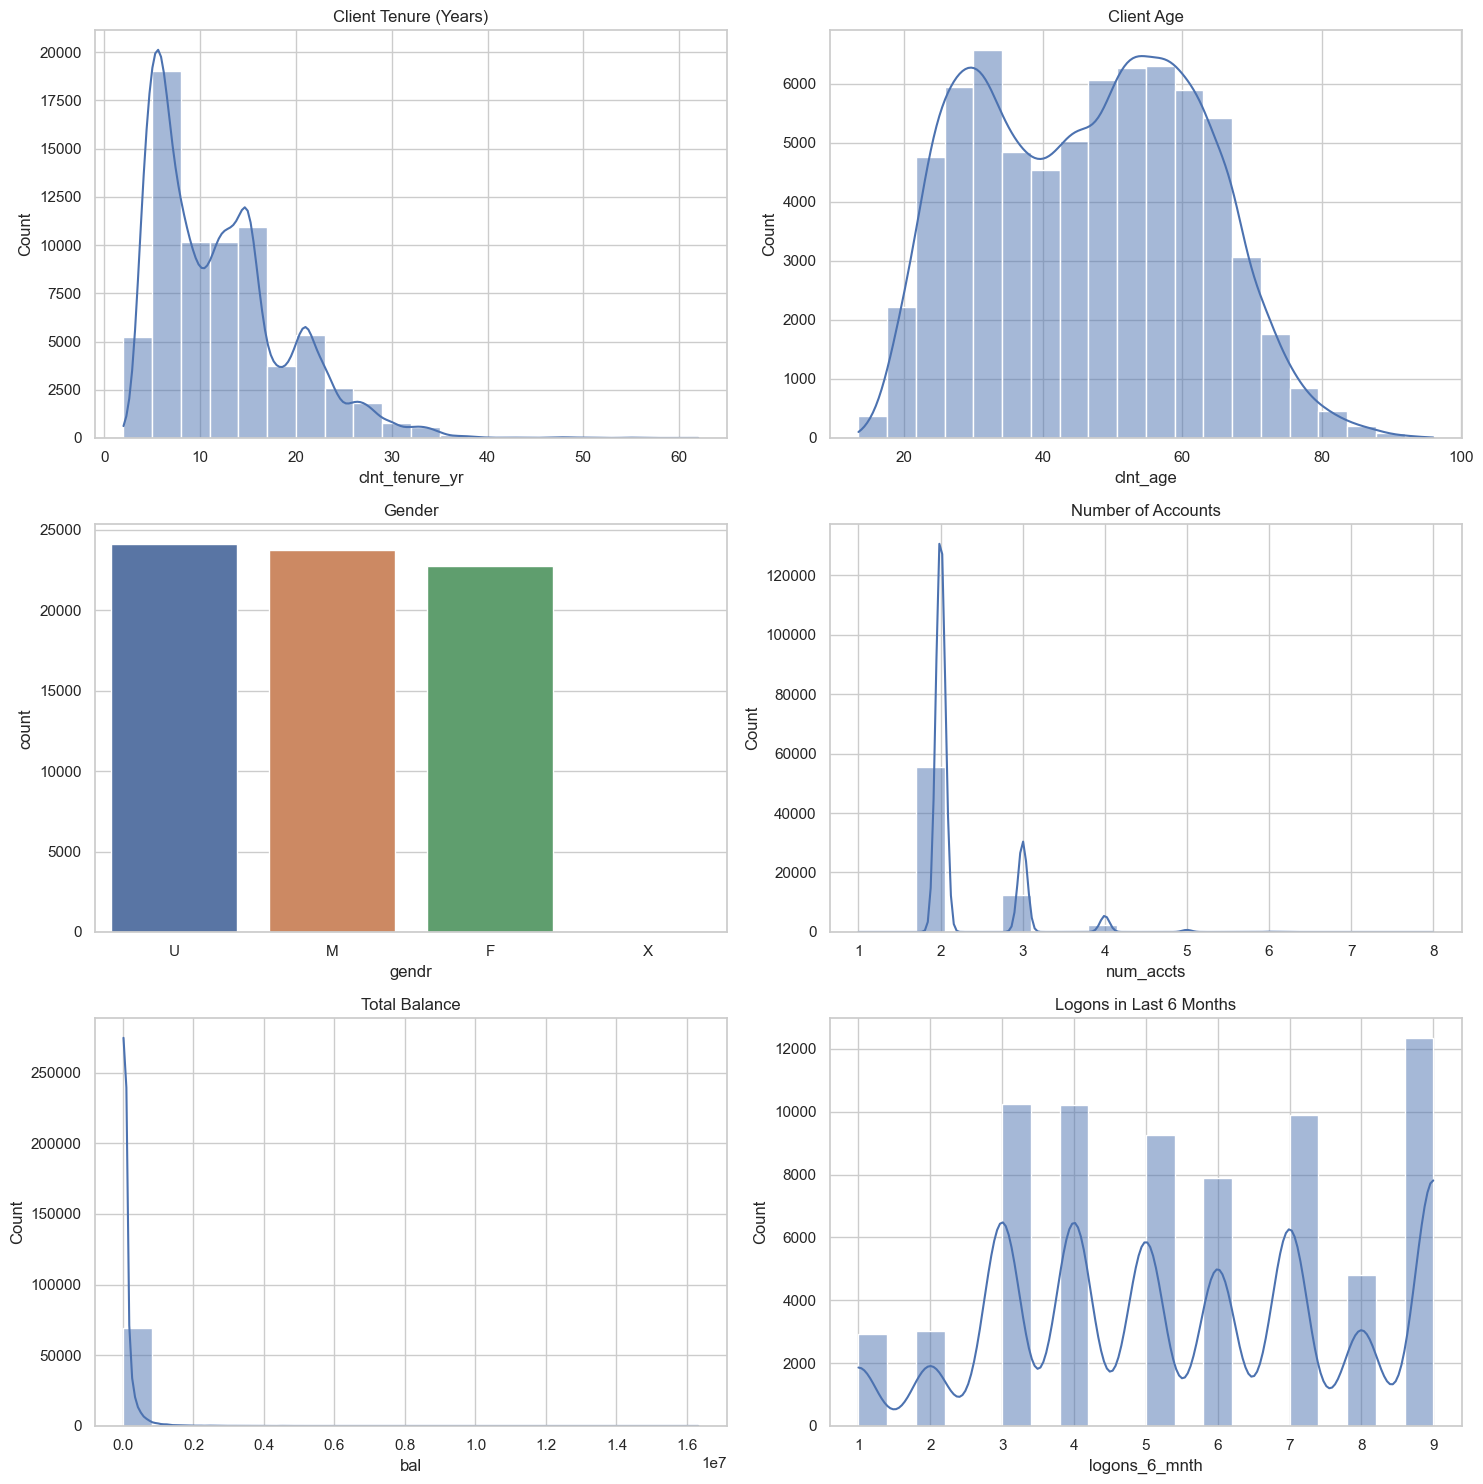

In [12]:
# Setting up the plotting style
sns.set(style="whitegrid")

# Plot distributions of demographic variables
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

sns.histplot(df_demo['clnt_tenure_yr'], bins=20, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Client Tenure (Years)')

sns.histplot(df_demo['clnt_age'], bins=20, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Client Age')

sns.countplot(data=df_demo, x='gendr', ax=axs[1, 0])
axs[1, 0].set_title('Gender')

sns.histplot(df_demo['num_accts'], bins=20, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Number of Accounts')

sns.histplot(df_demo['bal'], bins=20, kde=True, ax=axs[2, 0])
axs[2, 0].set_title('Total Balance')

sns.histplot(df_demo['logons_6_mnth'], bins=20, kde=True, ax=axs[2, 1])
axs[2, 1].set_title('Logons in Last 6 Months')

# sns.histplot(df_demo['calls_6_mnth'], bins=20, kde=True, ax=axs[2, 1])
# axs[2, 1].set_title('Calls in Last 6 Months')

plt.tight_layout()
plt.show()

In [13]:
# Get the list of client_ids from the filtered web data
client_ids_in_period = df_web_data['client_id'].unique()

# Filter the demographic data to include only those client_ids
df_demo_filtered = df_demo_with_exp[df_demo_with_exp['client_id'].isin(client_ids_in_period)]

# Group by variation and calculate summary statistics
demographic_summary_filtered = df_demo_filtered.groupby('variation').agg({
    'clnt_age': ['mean', 'std'],
    'clnt_tenure_yr': ['mean', 'std'],
    'num_accts': ['mean', 'std'],
    'bal': ['mean', 'std'],
    'calls_6_mnth': ['mean', 'std'],
    'logons_6_mnth': ['mean', 'std']
}).reset_index()

demographic_summary_filtered

variation   clnt_age            clnt_tenure_yr           num_accts  \
                  mean        std           mean       std      mean   
0   Control  47.498427  15.521781      12.087686  6.877531  2.259914   
1      Test  47.163922  15.514461      11.982901  6.844947  2.249917   

                       bal                calls_6_mnth            \
        std           mean            std         mean       std   
0  0.538559  150147.326660  295806.950360     3.129213  2.184502   
1  0.529335  148962.605032  307373.713775     3.061941  2.190590   

  logons_6_mnth            
           mean       std  
0      6.166277  2.173014  
1      6.101851  2.177119

<b>Age:</b> The average age of clients is similar between the control (51.95 years) and test (51.2 years) groups.

<b>Tenure:</b> The average tenure in years is slightly higher in the control group (12.76 years) compared to the test group (11.88 years).

<b>Accounts:</b> The number of accounts is nearly identical between the two groups.

<b>Balance:</b> The average balance is similar between the control and test groups, but slightly higher in the control groups

<b>Calls and Logons:</b> Both groups have similar engagement metrics in terms of calls and logons over the last 6 months.

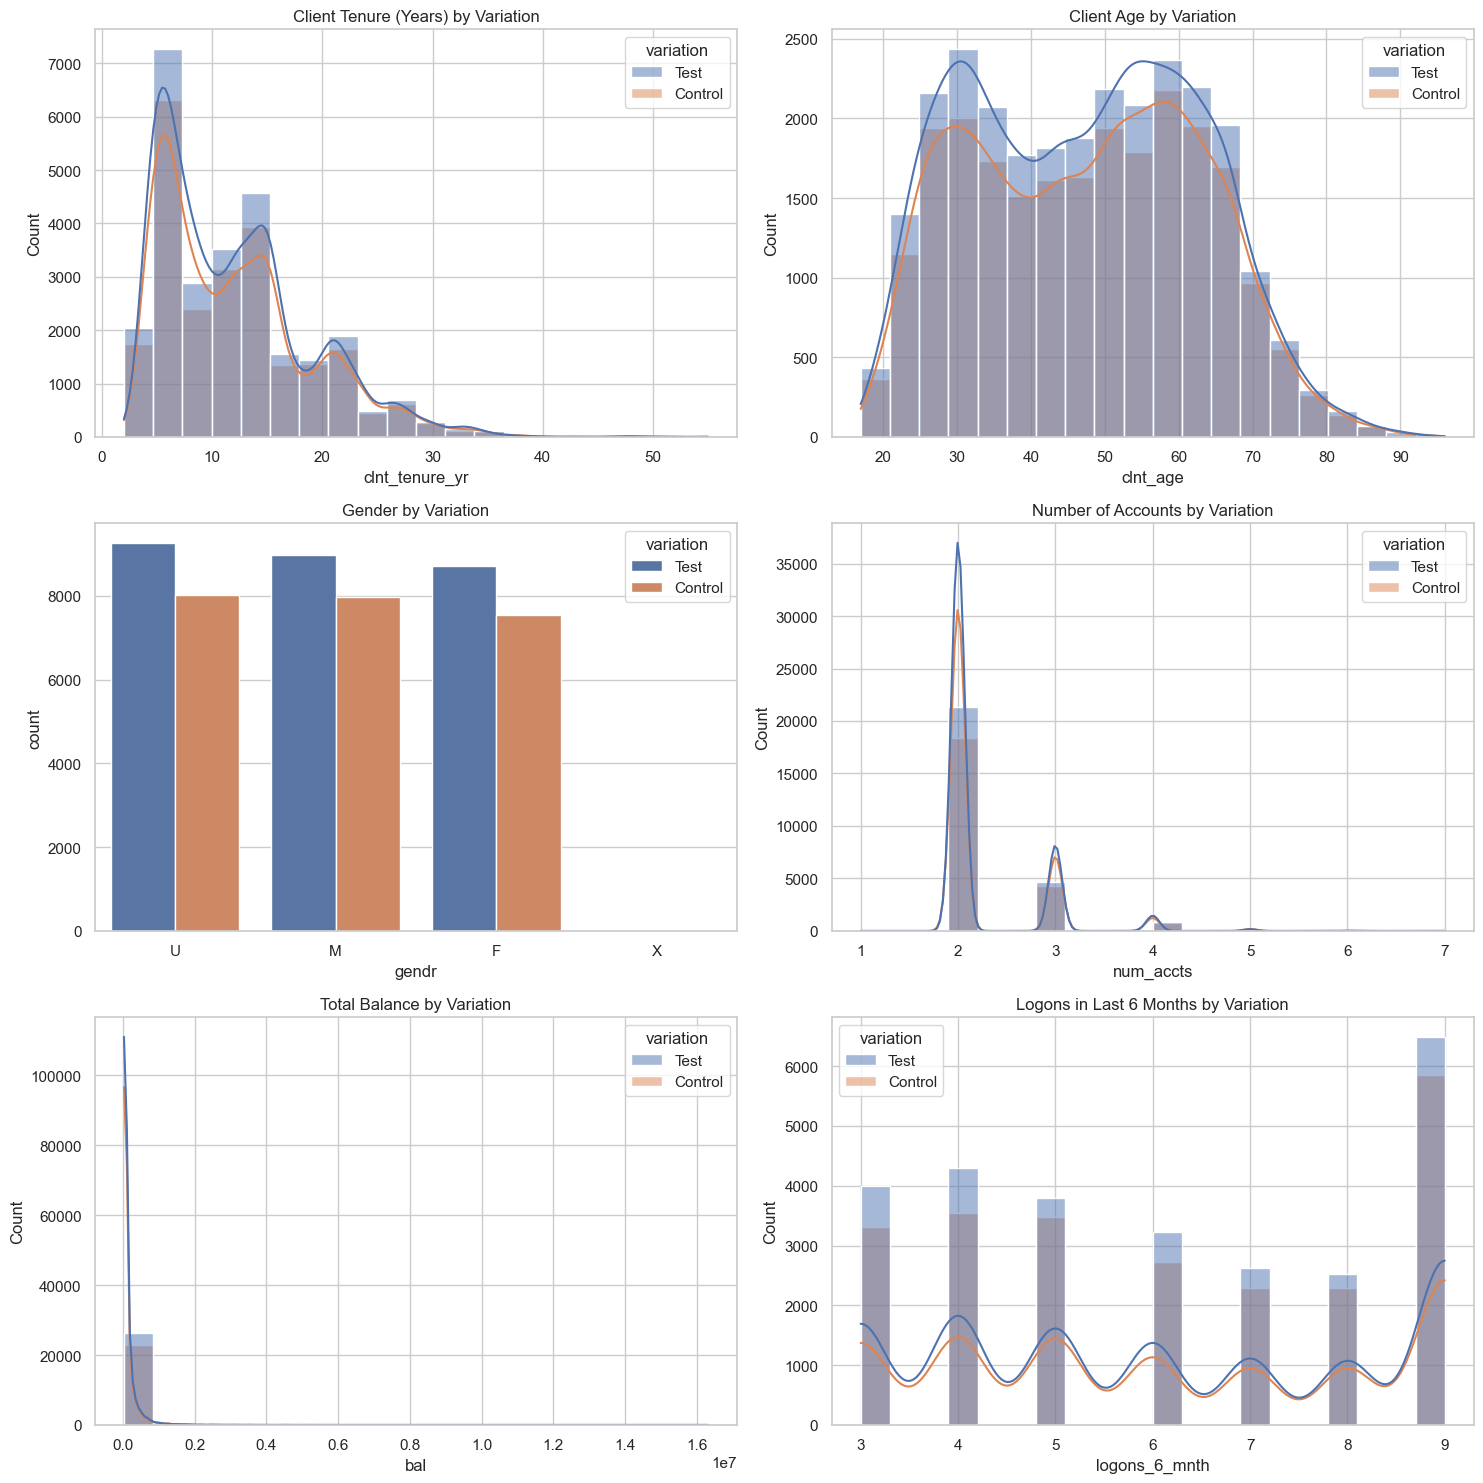

In [14]:
# Ensure the required data is available in df_demo_with_exp
# Setting up the plotting style
sns.set(style="whitegrid")

# Plot distributions of demographic variables
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

sns.histplot(data=df_demo_with_exp, x='clnt_tenure_yr', hue='variation', bins=20, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Client Tenure (Years) by Variation')

sns.histplot(data=df_demo_with_exp, x='clnt_age', hue='variation', bins=20, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Client Age by Variation')

sns.countplot(data=df_demo_with_exp, x='gendr', hue='variation', ax=axs[1, 0])
axs[1, 0].set_title('Gender by Variation')

sns.histplot(data=df_demo_with_exp, x='num_accts', hue='variation', bins=20, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Number of Accounts by Variation')

sns.histplot(data=df_demo_with_exp, x='bal', hue='variation', bins=20, kde=True, ax=axs[2, 0])
axs[2, 0].set_title('Total Balance by Variation')

sns.histplot(data=df_demo_with_exp, x='logons_6_mnth', hue='variation', bins=20, kde=True, ax=axs[2, 1])
axs[2, 1].set_title('Logons in Last 6 Months by Variation')

# sns.histplot(data=df_demo_with_exp, x='calls_6_mnth', hue='variation', bins=20, kde=True, ax=axs[2, 1])
# axs[2, 1].set_title('Calls in Last 6 Months by Variation')

plt.tight_layout()
plt.show()

Client Tenure (Years): The distribution of client tenure shows a range of values with a peak around 5-10 years.

Client Age: The age distribution is broad, with notable peaks around 30 and 60 years.

Gender: The gender distribution indicates a fairly balanced representation with some clients marked as 'U' (unknown).

Number of Accounts: Most clients have between 1 and 5 accounts.

Total Balance: The total balance of all accounts for clients varies widely, with some clients having significantly higher balances.

Logons in Last 6 Months: The frequency of logons in the last 6 months also shows variation, with a significant number of clients logging on 5-15 times.

# Understanding Client Interactions with the Process:
1) Interaction Patterns: Compare the frequency and sequence of process steps between the control and test groups.

2) Completion Rates: Calculate the completion rates for both groups (i.e., reaching the confirm page).

3) Time Spent: Analyze the average time spent on each step by clients in both groups.

Summary Statistics by Variation:
  variation   clnt_age                         \
                  mean        std   min   max   
0   Control  48.284478  15.620775  17.0  96.0   
1      Test  48.722216  15.646423  17.0  96.0   

                                          gendr clnt_tenure_yr                 \
                                       <lambda>           mean       std  min   
0          {'U': 48438, 'M': 47415, 'F': 44641}      12.167438  6.980731  2.0   
1  {'M': 59288, 'U': 59176, 'F': 58169, 'X': 8}      12.182025  6.940522  2.0   

         ...       bal              calls_6_mnth                      \
    max  ...       min          max         mean       std  min  max   
0  55.0  ...  23789.61   8292996.21     3.267755  2.184313  0.0  6.0   
1  55.0  ...  23789.44  16320040.15     3.201986  2.201277  0.0  6.0   

  logons_6_mnth                      
           mean       std  min  max  
0      6.303614  2.171134  3.0  9.0  
1      6.242124  2.186744  3.0  9.0  

[2 

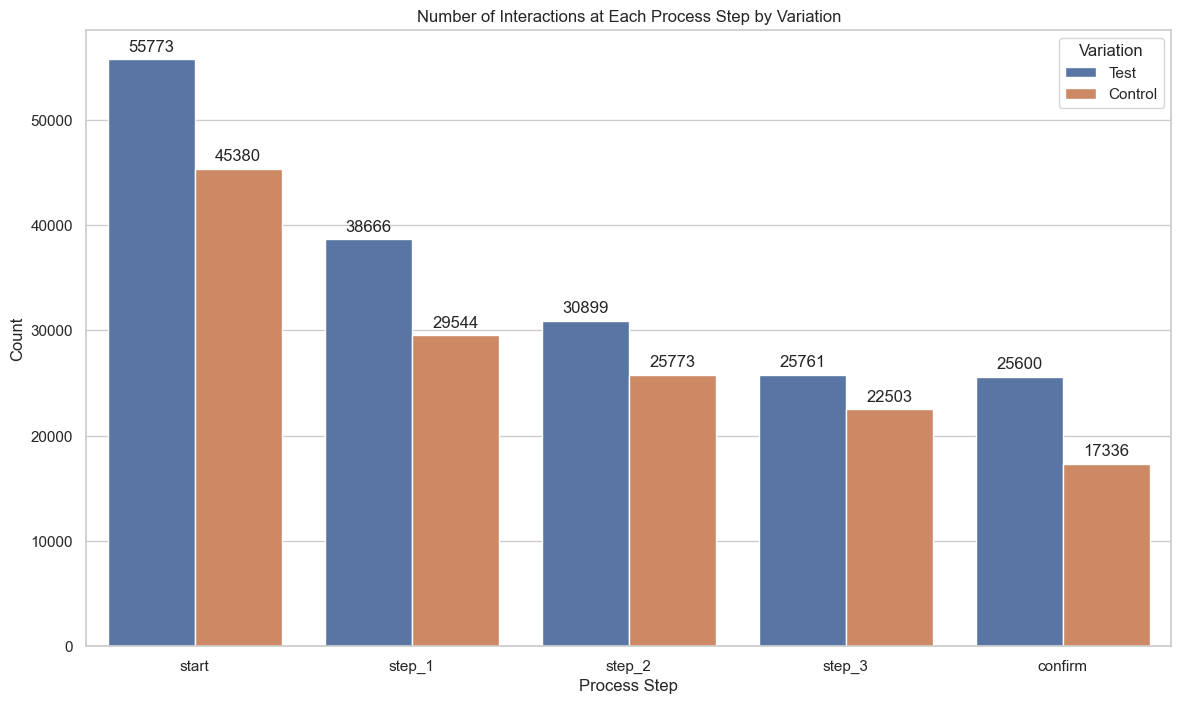

In [15]:
# Ensure steps are ordered correctly
required_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_full['process_step'] = pd.Categorical(df_full['process_step'], categories=required_steps, ordered=True)

# Summary statistics for each characteristic by Variation (Test vs. Control)
summary_stats = df_full.groupby('variation').agg({
    'clnt_age': ['mean', 'std', 'min', 'max'],
    'gendr': lambda x: x.value_counts().to_dict(),
    'clnt_tenure_yr': ['mean', 'std', 'min', 'max'],
    'num_accts': ['mean', 'std', 'min', 'max'],
    'bal': ['mean', 'std', 'min', 'max'],
    'calls_6_mnth': ['mean', 'std', 'min', 'max'],
    'logons_6_mnth': ['mean', 'std', 'min', 'max']
}).reset_index()

print("Summary Statistics by Variation:")
print(summary_stats)

# Count the number of interactions at each process step by Variation and client characteristics
interaction_patterns = df_full.groupby(['variation', 'process_step']).agg({
    'client_id': 'count',
    'clnt_age': 'mean',
    'gendr': lambda x: x.value_counts().to_dict(),
    'clnt_tenure_yr': 'mean',
    'num_accts': 'mean',
    'bal': 'mean',
    'calls_6_mnth': 'mean',
    'logons_6_mnth': 'mean'
}).reset_index()

print("Interaction Patterns by Variation and Process Step:")
print(interaction_patterns)

# Plotting interaction patterns with labels
plt.figure(figsize=(14, 8))
bar_plot = sns.countplot(x='process_step', hue='variation', data=df_full, order=required_steps)
plt.title('Number of Interactions at Each Process Step by Variation')
plt.xlabel('Process Step')
plt.ylabel('Count')
plt.legend(title='Variation')

# Add labels to the bars
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.annotate(format(height, '.0f'), 
                      (p.get_x() + p.get_width() / 2., height), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')

plt.show()


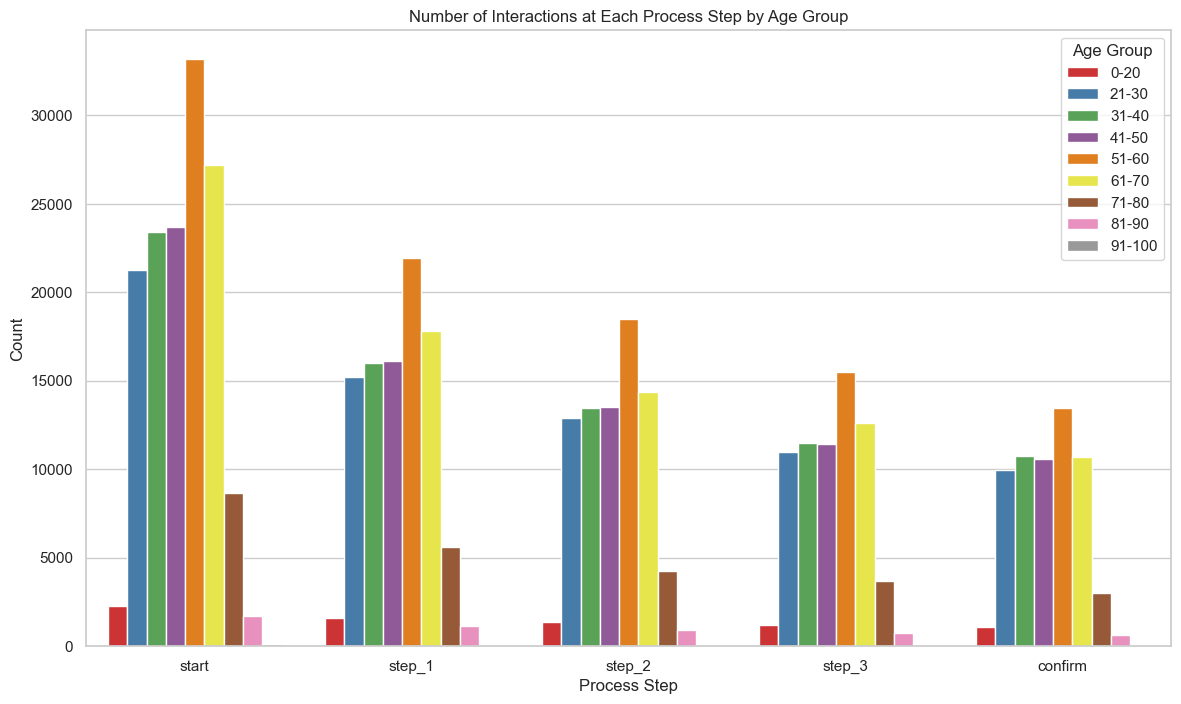

In [16]:
# Define age bins
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Add age group to the dataframe
df_full['age_group'] = pd.cut(df_full['clnt_age'], bins=age_bins, labels=age_labels, right=False)

# Count the number of interactions at each process step by Variation and age group
interaction_patterns_age = df_full.groupby(['variation', 'age_group', 'process_step']).agg({
    'client_id': 'count'
}).reset_index()

# Pivot the data for better visualization
interaction_patterns_age_pivot = interaction_patterns_age.pivot_table(index=['age_group', 'process_step'], columns='variation', values='client_id', fill_value=0)

interaction_patterns_age_pivot

# Plotting interaction patterns by age group and process step
plt.figure(figsize=(14, 8))
sns.countplot(x='process_step', hue='age_group', data=df_full, palette="Set1")
plt.title('Number of Interactions at Each Process Step by Age Group')
plt.xlabel('Process Step')
plt.ylabel('Count')
plt.legend(title='Age Group')
plt.show()

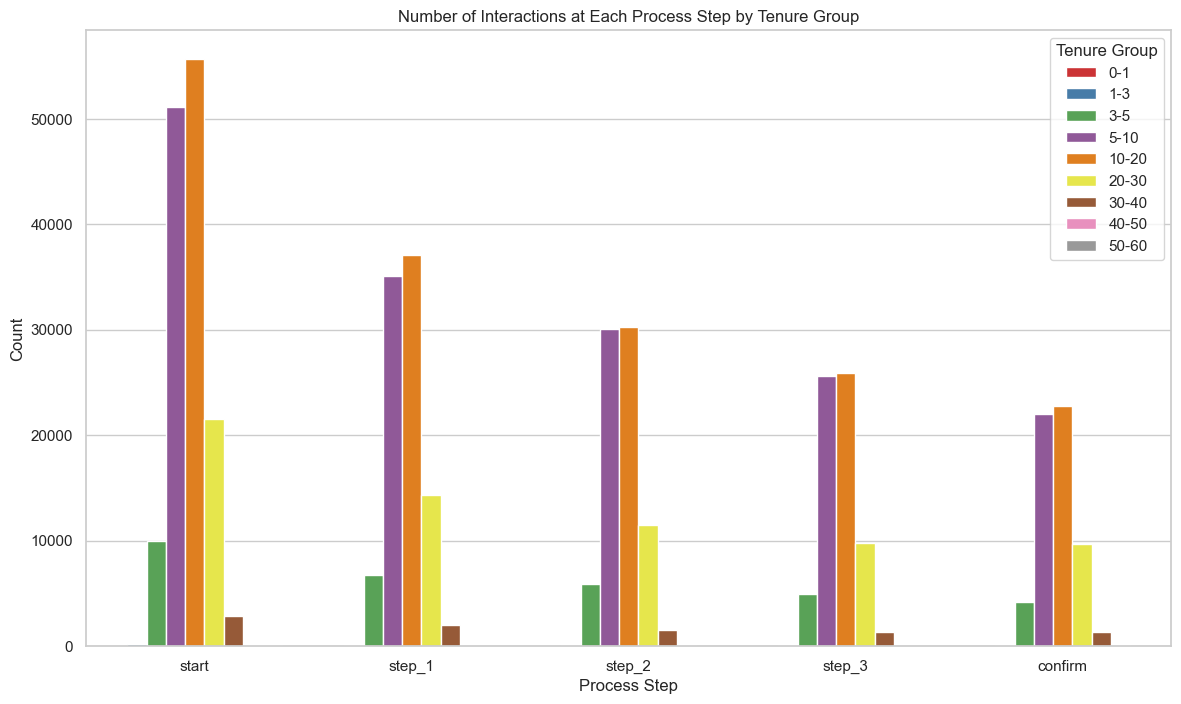

In [17]:
# Define tenure bins
tenure_bins = [0, 1, 3, 5, 10, 20, 30, 40, 50, 60]
tenure_labels = ['0-1', '1-3', '3-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60']

# Add tenure group to the dataframe
df_full['tenure_group'] = pd.cut(df_full['clnt_tenure_yr'], bins=tenure_bins, labels=tenure_labels, right=False)

# Count the number of interactions at each process step by Variation and tenure group
interaction_patterns_tenure = df_full.groupby(['variation', 'tenure_group', 'process_step']).agg({
    'client_id': 'count'
}).reset_index()

# Pivot the data for better visualization
interaction_patterns_tenure_pivot = interaction_patterns_tenure.pivot_table(index=['tenure_group', 'process_step'], columns='variation', values='client_id', fill_value=0)

interaction_patterns_tenure_pivot

# Plotting interaction patterns by tenure group and process step
plt.figure(figsize=(14, 8))
sns.countplot(x='process_step', hue='tenure_group', data=df_full, palette="Set1")
plt.title('Number of Interactions at Each Process Step by Tenure Group')
plt.xlabel('Process Step')
plt.ylabel('Count')
plt.legend(title='Tenure Group')
plt.show()

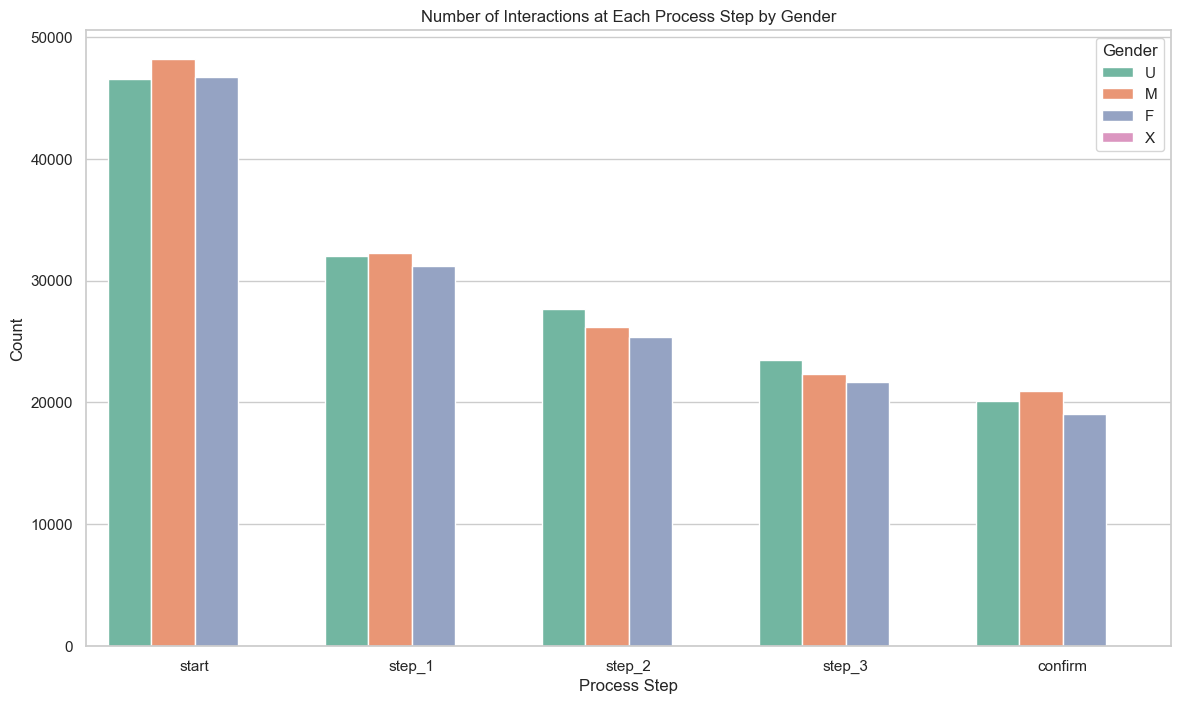

In [19]:
# Count the number of interactions at each process step by Variation and gender
interaction_patterns_gender = df_full.groupby(['variation', 'gendr', 'process_step']).agg({
    'client_id': 'count'
}).reset_index()

# Pivot the data for better visualization
interaction_patterns_gender_pivot = interaction_patterns_gender.pivot_table(index=['gendr', 'process_step'], columns='variation', values='client_id', fill_value=0)

interaction_patterns_gender_pivot

# Plotting interaction patterns by gender and process step
plt.figure(figsize=(14, 8))
sns.countplot(x='process_step', hue='gendr', data=df_full, palette="Set2")
plt.title('Number of Interactions at Each Process Step by Gender')
plt.xlabel('Process Step')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

  Variation  Completed  Average_Calls_6_Months
0   Control      False                3.273781
1   Control       True                3.224928
2      Test      False                3.183764
3      Test       True                3.309526


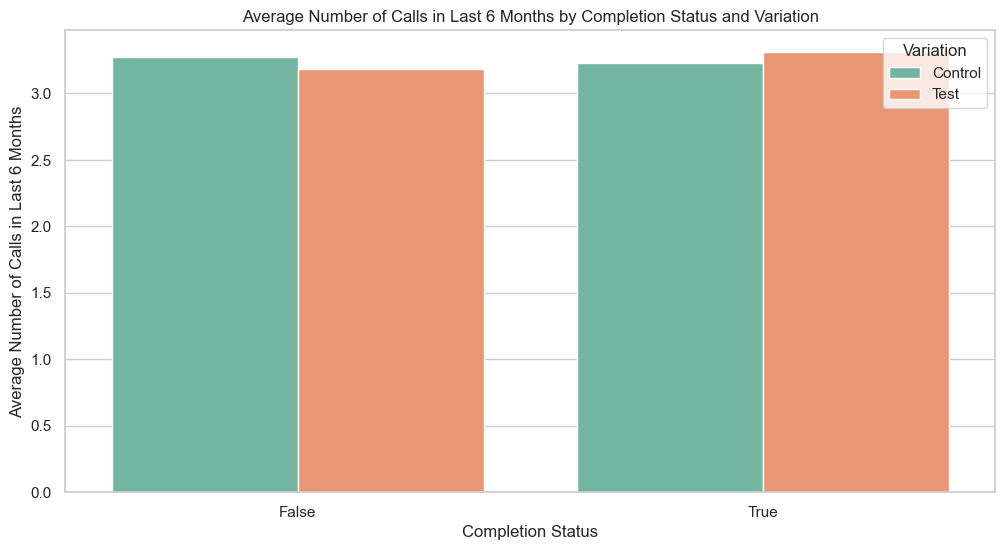

In [20]:
# Calculate completion status
df_full['completed'] = df_full['process_step'] == 'confirm'

# Group by variation and completion status and calculate the mean number of calls in the last 6 months
calls_completion_comparison = df_full.groupby(['variation', 'completed'])['calls_6_mnth'].mean().reset_index()

# Rename columns for clarity
calls_completion_comparison.columns = ['Variation', 'Completed', 'Average_Calls_6_Months']

print(calls_completion_comparison)

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Completed', y='Average_Calls_6_Months', hue='Variation', data=calls_completion_comparison, palette="Set2")
plt.title('Average Number of Calls in Last 6 Months by Completion Status and Variation')
plt.xlabel('Completion Status')
plt.ylabel('Average Number of Calls in Last 6 Months')
plt.legend(title='Variation')
plt.show()

  Variation  Completed  Average_Logons_6_Months
0   Control      False                 6.309287
1   Control       True                 6.263301
2      Test      False                 6.224665
3      Test       True                 6.345159


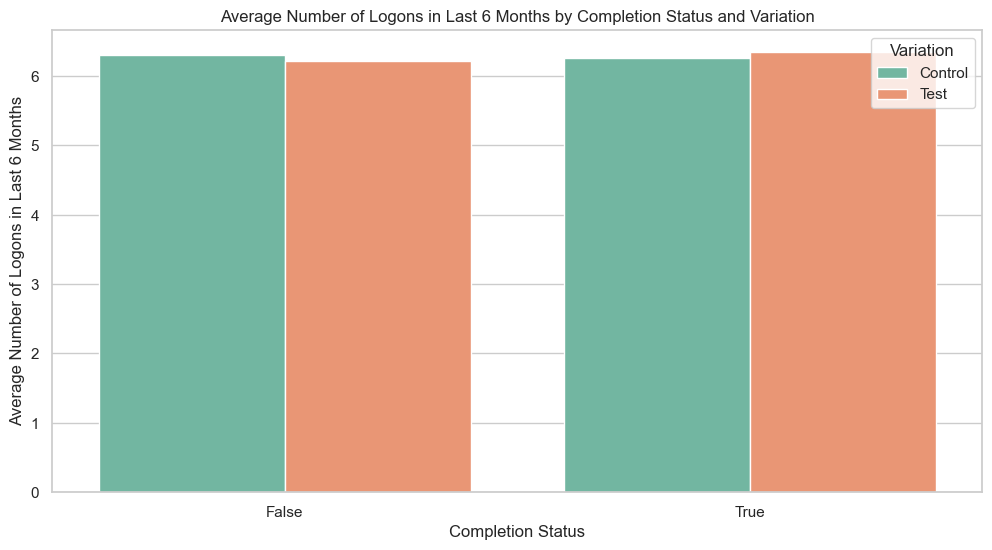

In [21]:
# Calculate completion status
df_full['completed'] = df_full['process_step'] == 'confirm'

# Group by variation and completion status and calculate the mean number of logons in the last 6 months
logons_completion_comparison = df_full.groupby(['variation', 'completed'])['logons_6_mnth'].mean().reset_index()

# Rename columns for clarity
logons_completion_comparison.columns = ['Variation', 'Completed', 'Average_Logons_6_Months']

print(logons_completion_comparison)

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Completed', y='Average_Logons_6_Months', hue='Variation', data=logons_completion_comparison, palette="Set2")
plt.title('Average Number of Logons in Last 6 Months by Completion Status and Variation')
plt.xlabel('Completion Status')
plt.ylabel('Average Number of Logons in Last 6 Months')
plt.legend(title='Variation')
plt.show()

  Variation  Completed  Average_Num_Accts
0   Control      False           2.270201
1   Control       True           2.290075
2      Test      False           2.244434
3      Test       True           2.308314


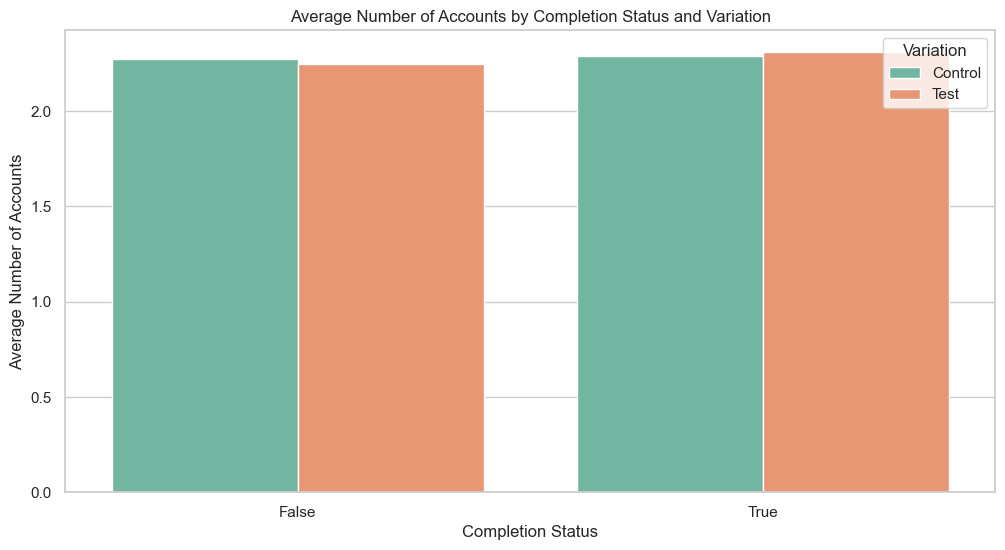

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_full is your DataFrame

# Calculate completion status
df_full['completed'] = df_full['process_step'] == 'confirm'

# Group by variation and completion status and calculate the mean number of accounts
accounts_completion_comparison = df_full.groupby(['variation', 'completed'])['num_accts'].mean().reset_index()

# Rename columns for clarity
accounts_completion_comparison.columns = ['Variation', 'Completed', 'Average_Num_Accts']

print(accounts_completion_comparison)

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Completed', y='Average_Num_Accts', hue='Variation', data=accounts_completion_comparison, palette="Set2")
plt.title('Average Number of Accounts by Completion Status and Variation')
plt.xlabel('Completion Status')
plt.ylabel('Average Number of Accounts')
plt.legend(title='Variation')
plt.show()

  variation  Completed  Average_Unique_Visits
0   Control      False               1.753856
1   Control       True               1.534379
2      Test      False               1.658449
3      Test       True               1.798047


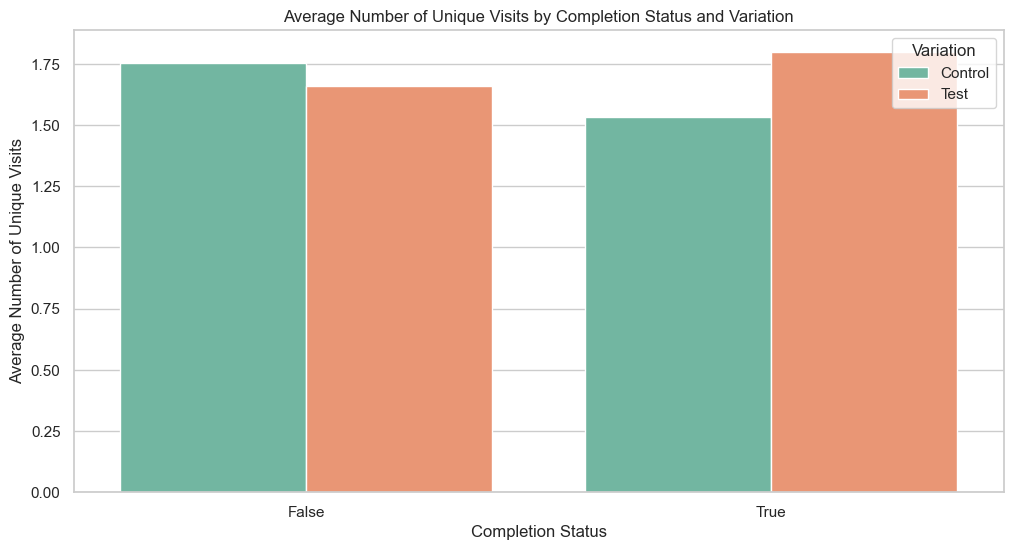

In [23]:
# Calculate the number of unique visit_id for each client
df_full['unique_visits'] = df_full.groupby('client_id')['visit_id'].transform('nunique')

# Group by variation and completion status and calculate the mean number of unique visits
visits_completion_comparison = df_full.groupby(['variation', 'completed'])['unique_visits'].mean().reset_index()

# Rename columns for clarity
visits_completion_comparison.columns = ['variation', 'Completed', 'Average_Unique_Visits']

print(visits_completion_comparison)

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Completed', y='Average_Unique_Visits', hue='variation', data=visits_completion_comparison, palette="Set2")
plt.title('Average Number of Unique Visits by Completion Status and Variation')
plt.xlabel('Completion Status')
plt.ylabel('Average Number of Unique Visits')
plt.legend(title='Variation')
plt.show()

  variation  Completed  Average_Balance
0   Control      False    158847.721780
1   Control       True    159114.357020
2      Test      False    159184.988413
3      Test       True    180843.060463


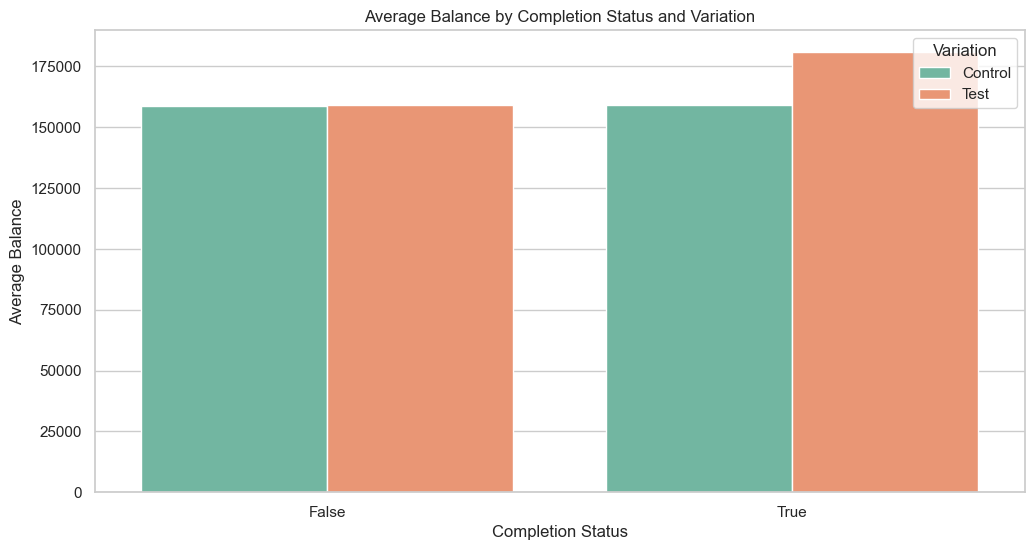

In [24]:
# Group by variation and completion status and calculate the mean balance
balance_completion_comparison = df_full.groupby(['variation', 'completed'])['bal'].mean().reset_index()

# Rename columns for clarity
balance_completion_comparison.columns = ['variation', 'Completed', 'Average_Balance']

print(balance_completion_comparison)

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Completed', y='Average_Balance', hue='variation', data=balance_completion_comparison, palette="Set2")
plt.title('Average Balance by Completion Status and Variation')
plt.xlabel('Completion Status')
plt.ylabel('Average Balance')
plt.legend(title='Variation')
plt.show()

  variation  Completed  Average_Tenure_Years
0   Control      False             12.147616
1   Control       True             12.308309
2      Test      False             12.138612
3      Test       True             12.438228


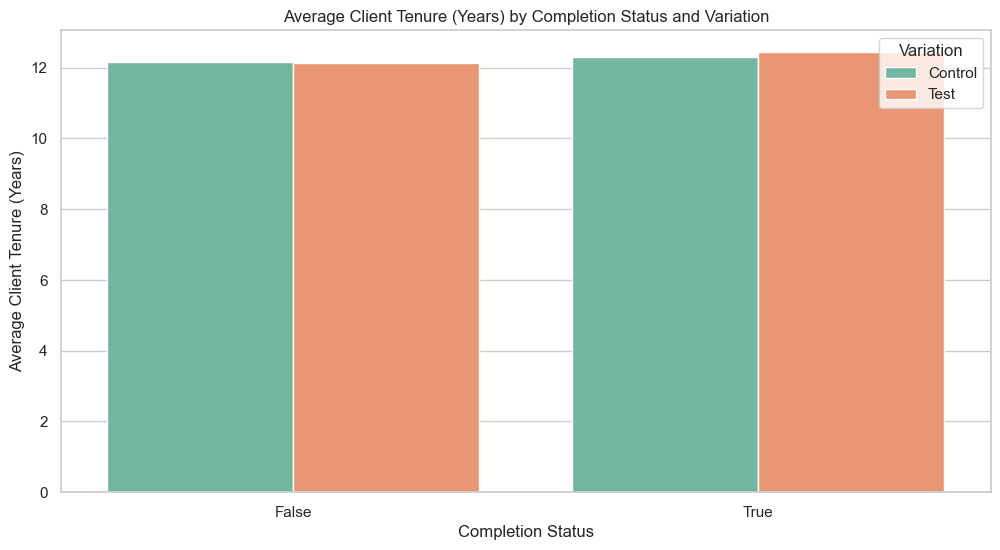

In [25]:
# Group by variation and completion status and calculate the mean client tenure in years
tenure_completion_comparison = df_full.groupby(['variation', 'completed'])['clnt_tenure_yr'].mean().reset_index()

# Rename columns for clarity
tenure_completion_comparison.columns = ['variation', 'Completed', 'Average_Tenure_Years']

print(tenure_completion_comparison)

# Plotting the results
plt.figure(figsize=(12, 6))
sns.barplot(x='Completed', y='Average_Tenure_Years', hue='variation', data=tenure_completion_comparison, palette="Set2")
plt.title('Average Client Tenure (Years) by Completion Status and Variation')
plt.xlabel('Completion Status')
plt.ylabel('Average Client Tenure (Years)')
plt.legend(title='Variation')
plt.show()

# How can success be measured in the experimental new process? 

The success of the experimental process can be measured by a marked decrease in drop off rate, an increase in completion rate, and the reduced time spent on each step.

# How did the new process perform? 

In [26]:
# Establish start and end dates for later analysis
start_date = '2017-03-15'
end_date = '2017-04-30'

df_with_old_dates = df_full
df_full = df_full[(df_full['date_time'] >= start_date) & (df_full['date_time'] <= end_date)]

In [27]:
# Check for clients in the experiment who didn't reach the 'start' process step
experiment_clients = df_experiment_clients['client_id'].unique()
clients_reached_start = df_full[df_full['process_step'] == 'start']['client_id'].unique()
clients_did_not_reach_start = set(experiment_clients) - set(clients_reached_start)

clients_in_experiment = df_full[df_full['variation'] != 'None']['client_id'].nunique()
number_of_clients_did_not_reach_start = len(clients_did_not_reach_start)

print(f"Number of clients in the experiment : {clients_in_experiment}")
print(f"Number of clients in the experiment who didn't reach the 'start' process step: {number_of_clients_did_not_reach_start}")

Number of clients in the experiment : 55939
Number of clients in the experiment who didn't reach the 'start' process step: 15093


In [28]:
# Check for clients in the experiment who didn't reach the 'start' process step
experiment_clients = df_experiment_clients['client_id'].unique()
clients_reached_start = df_full[df_full['process_step'] == 'start']['client_id'].unique()
clients_did_not_reach_start = set(experiment_clients) - set(clients_reached_start)

number_of_clients_did_not_reach_start = len(clients_did_not_reach_start)
print(f"Number of clients in the experiment who didn't reach the 'start' process step: {number_of_clients_did_not_reach_start}")

Number of clients in the experiment who didn't reach the 'start' process step: 15093


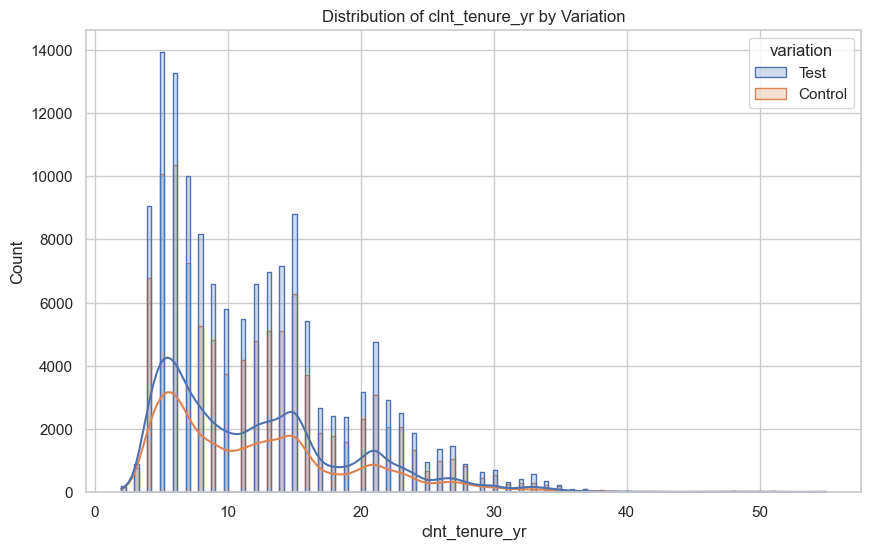

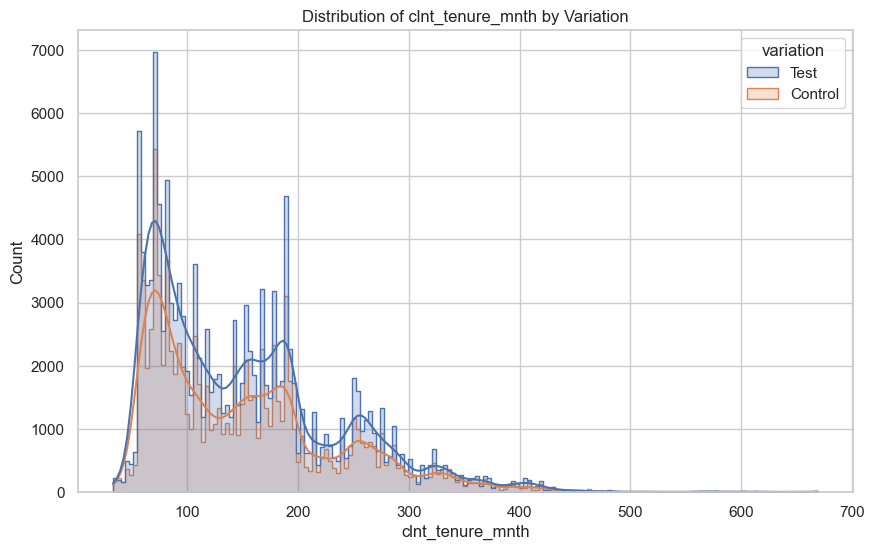

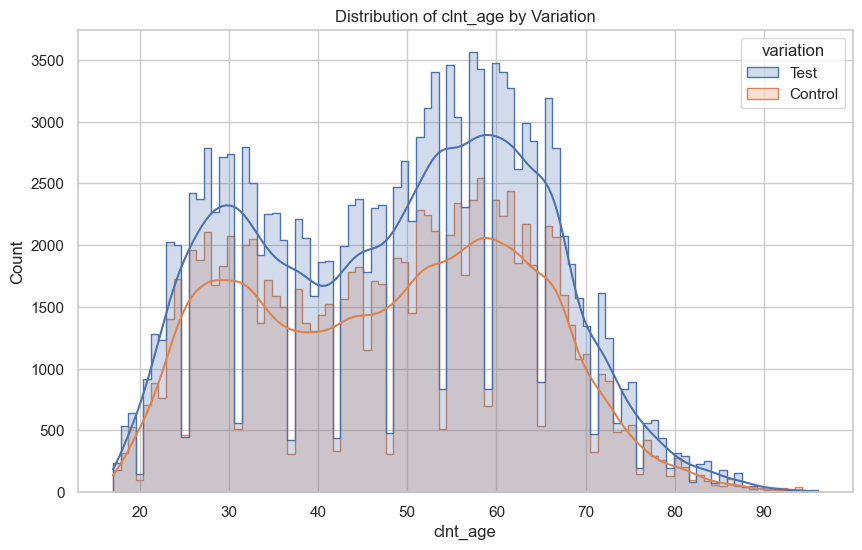

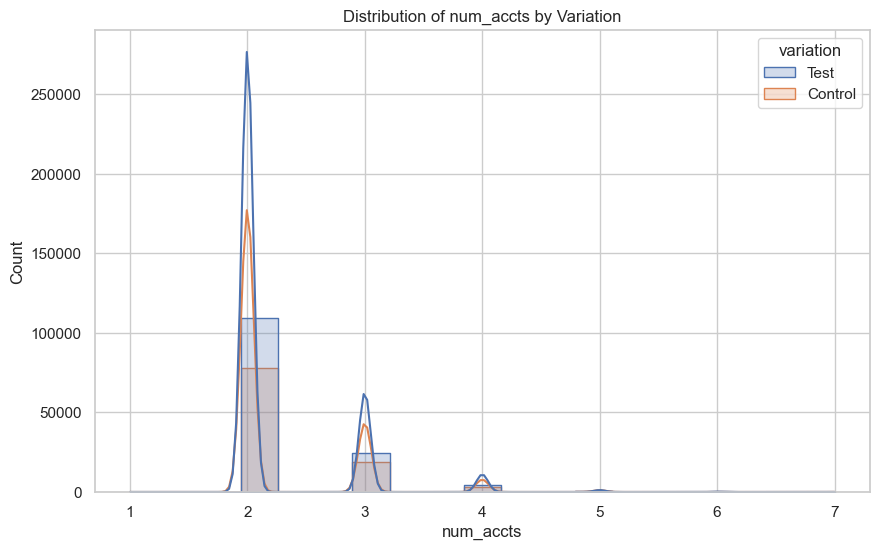

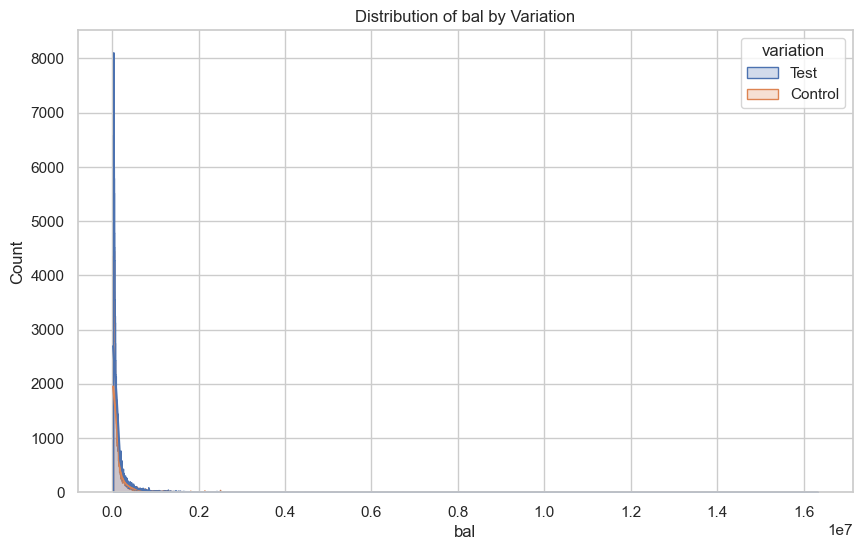

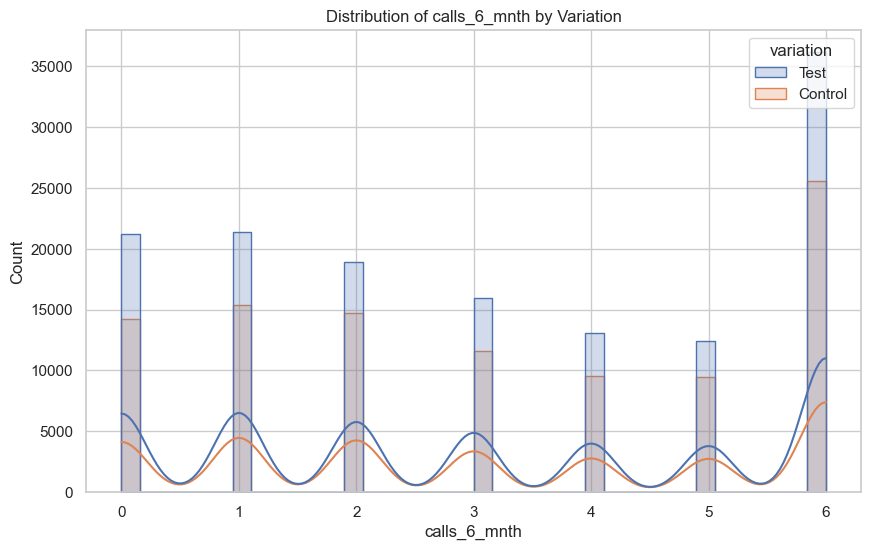

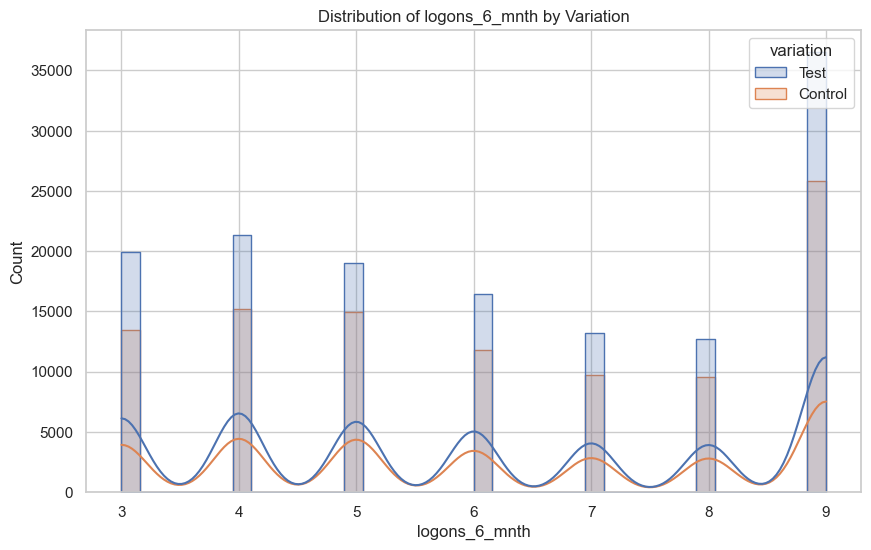

In [29]:
# Examine the distribution of user characteristics between control and test groups
user_characteristics = ['clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']
df_characteristics = df_full[user_characteristics + ['variation']]

# Plot the distribution of each characteristic
for characteristic in user_characteristics:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_characteristics, x=characteristic, hue='variation', kde=True, element="step")
    plt.title(f'Distribution of {characteristic} by Variation')
    plt.show()

# Evaluation of Experiment

in the timeframe of 3/15/2017 through 4/30/2017

# How effective was the experiment design?

Chi-Square Test Results for Completion Rates:
 {'chi2': 118.01530753678529, 'p-value': 1.720550264096442e-27, 'dof': 1}


/Users/User/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


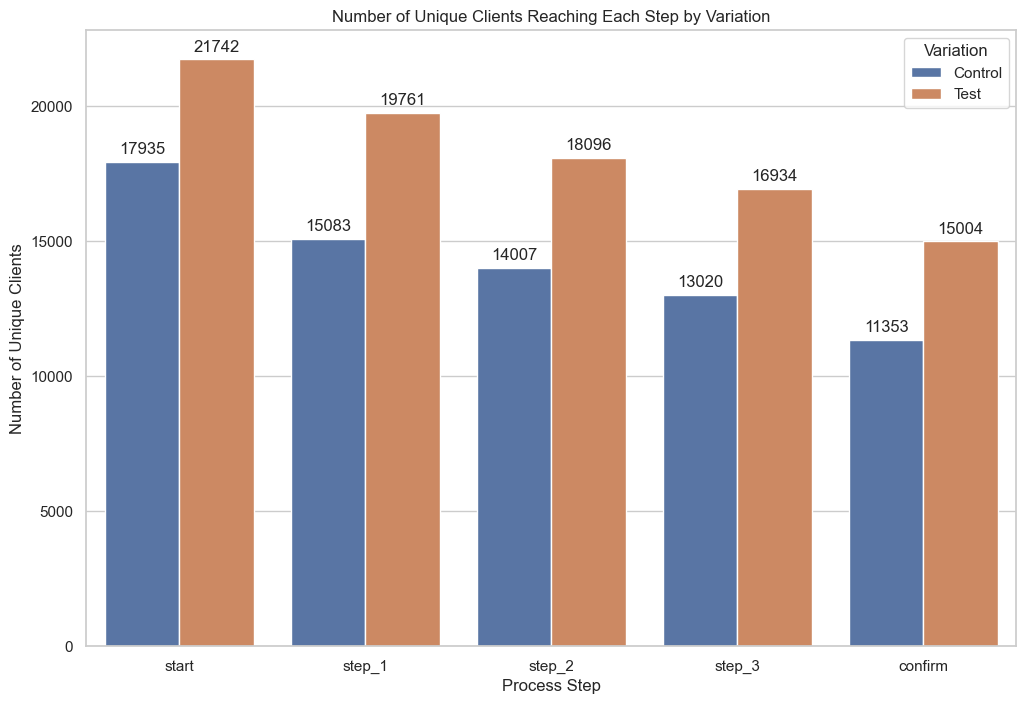

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


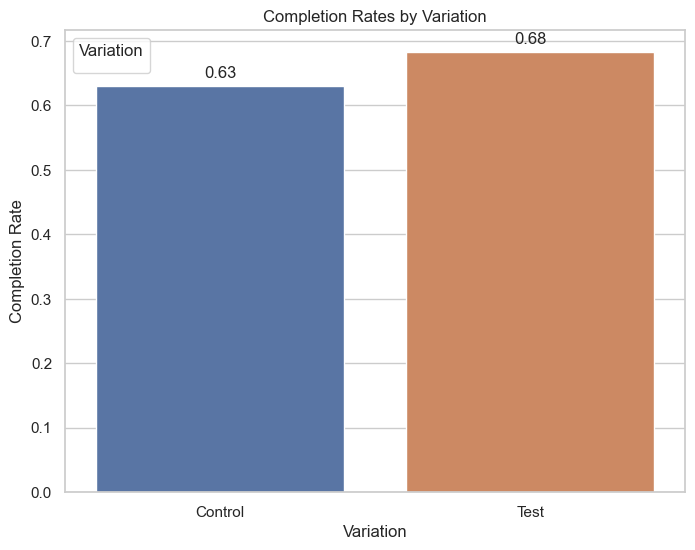

In [30]:
# Ensure the steps are ordered correctly
required_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_full['process_step'] = pd.Categorical(df_full['process_step'], categories=required_steps, ordered=True)

# Calculate the number of unique clients reaching each step by variation
interaction_counts = df_full.groupby(['variation', 'process_step'])['client_id'].nunique().reset_index()

# Calculate completion rates for each variation
completion_counts = df_full[df_full['process_step'] == 'confirm'].groupby('variation')['client_id'].nunique().reset_index()
completion_counts.columns = ['variation', 'completed_clients']
total_clients = df_full.groupby('variation')['client_id'].nunique().reset_index()
total_clients.columns = ['variation', 'total_clients']
completion_rates_period = pd.merge(completion_counts, total_clients, on='variation')
completion_rates_period['completion_rate'] = completion_rates_period['completed_clients'] / completion_rates_period['total_clients']

# Create a contingency table for chi-square test
completion_counts['not_completed_clients'] = total_clients['total_clients'] - completion_counts['completed_clients']
contingency_table = completion_counts[['completed_clients', 'not_completed_clients']].T

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print Chi-Square Test Results
chi_square_results = {'chi2': chi2, 'p-value': p, 'dof': dof}
print("Chi-Square Test Results for Completion Rates:\n", chi_square_results)

# Plot interaction counts
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=interaction_counts, x='process_step', y='client_id', hue='variation', order=required_steps)
plt.title('Number of Unique Clients Reaching Each Step by Variation')
plt.xlabel('Process Step')
plt.ylabel('Number of Unique Clients')
plt.legend(title='Variation')
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')
plt.show()

# Plot completion rates
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(data=completion_rates_period, x='variation', y='completion_rate')
plt.title('Completion Rates by Variation')
plt.xlabel('Variation')
plt.ylabel('Completion Rate')
plt.legend(title='Variation')
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')
plt.show()

<b>Chi-square Test for Completion Rates</b>
* Control: The completion rate is about 11% with narrow confidence interval, indicating that the true completion rate is likely to be very close to this value.
* Test: The completion rate is about 14% with asimilarly narrow confidence interval.
* x^2 is very large and the p-value is extremely small (almost zero). This would indicate statistical significance for completion rates.
* Since p-value is less than 0.05, we would reject the null hypothesis that there is no difference in completion rates between the two groups. 
* Thus, the experiment's changes had a significant effect on the completion rates.

/Users/User/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/User/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


T-Test Results for Average Time Spent at Each Step:
 {'start': {'t-statistic': 5.45187389415319, 'p-value': 5.080969523156929e-08}, 'step_1': {'t-statistic': 2.4760559697226165, 'p-value': 0.013306380397144404}, 'step_2': {'t-statistic': -6.3754713043798725, 'p-value': 1.9110240981532376e-10}, 'step_3': {'t-statistic': -13.59882883090571, 'p-value': 1.9573044910791551e-41}, 'confirm': {'t-statistic': -23.154958421396536, 'p-value': 1.2042577908653237e-110}}


/Users/User/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


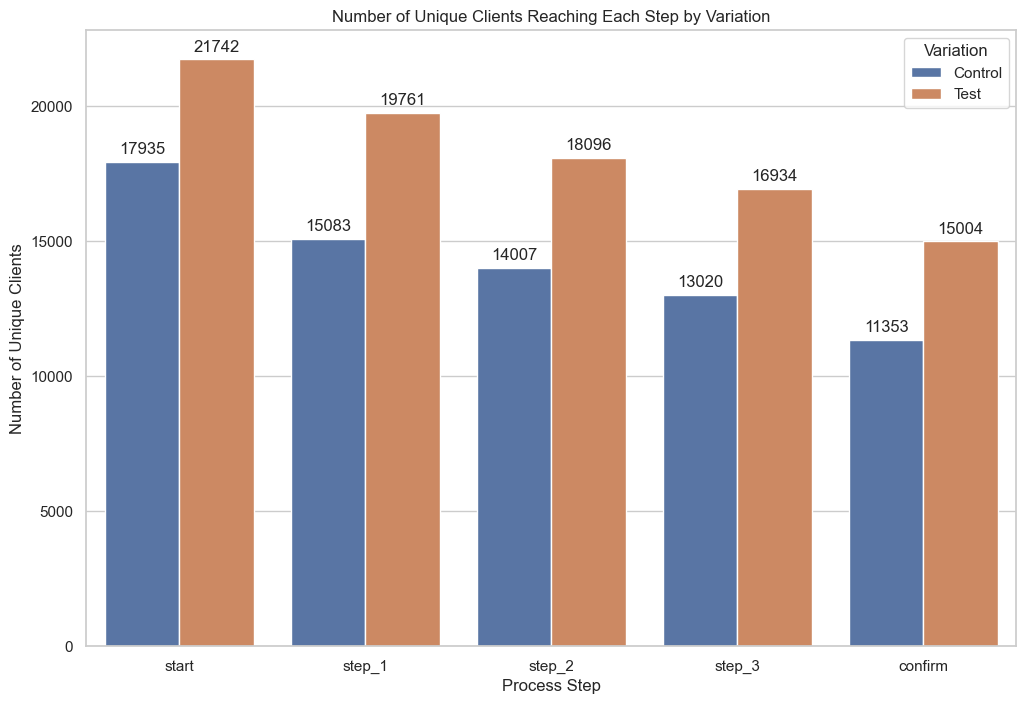

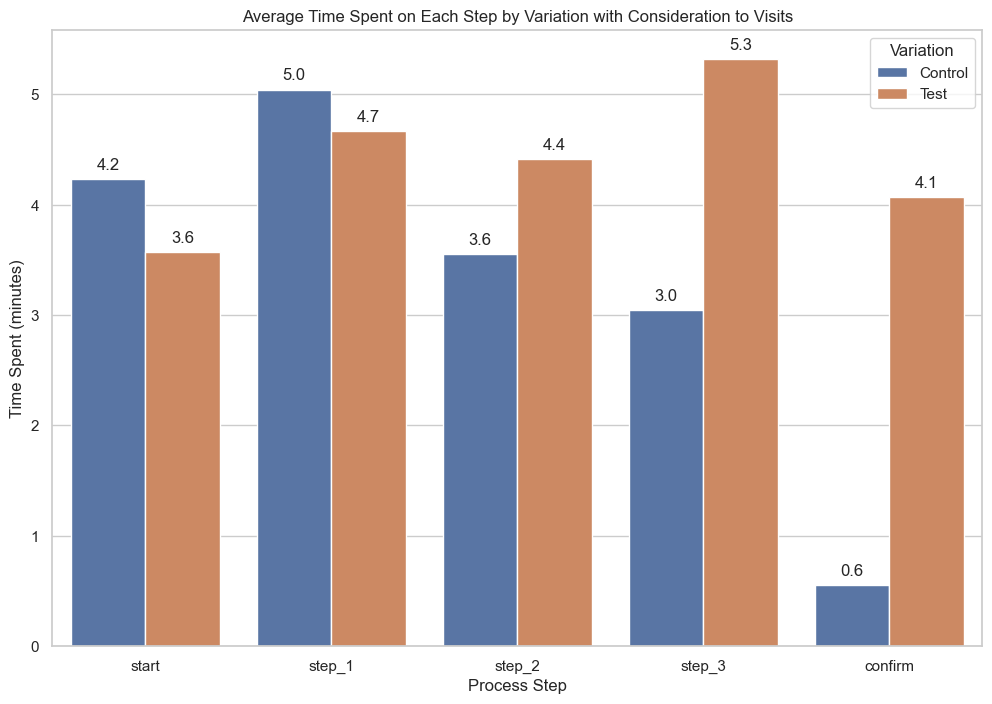

In [31]:
# Ensure the steps are ordered correctly
required_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_full['process_step'] = pd.Categorical(df_full['process_step'], categories=required_steps, ordered=True)

# Convert date_time to datetime and sort the dataframe
df_full['date_time'] = pd.to_datetime(df_full['date_time'])
df_full = df_full.sort_values(by=['client_id', 'visit_id', 'date_time'])

# Calculate the time difference for each step
df_full['time_diff'] = df_full.groupby(['client_id', 'visit_id', 'process_step'])['date_time'].diff()

# Remove entries with no time_diff (NaN)
df_time_spent = df_full.dropna(subset=['time_diff'])

# Convert time_diff to minutes for analysis
df_time_spent['time_diff_minutes'] = df_time_spent['time_diff'].dt.total_seconds() / 60

# Aggregate total time spent on each step
time_spent = df_time_spent.groupby(['variation', 'process_step'])['time_diff_minutes'].mean().reset_index()

# Perform T-Tests to compare the average time spent between control and test groups
t_test_results = {}
for step in required_steps:
    control_times = df_time_spent[(df_time_spent['variation'] == 'Control') & (df_time_spent['process_step'] == step)]['time_diff_minutes']
    test_times = df_time_spent[(df_time_spent['variation'] == 'Test') & (df_time_spent['process_step'] == step)]['time_diff_minutes']
    t_stat, p_val = ttest_ind(control_times, test_times, equal_var=False, nan_policy='omit')
    t_test_results[step] = {'t-statistic': t_stat, 'p-value': p_val}

# Print T-Test Results
print("T-Test Results for Average Time Spent at Each Step:\n", t_test_results)

# Plot interaction counts
interaction_counts = df_full.groupby(['variation', 'process_step'])['client_id'].nunique().reset_index()
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=interaction_counts, x='process_step', y='client_id', hue='variation', order=required_steps)
plt.title('Number of Unique Clients Reaching Each Step by Variation')
plt.xlabel('Process Step')
plt.ylabel('Number of Unique Clients')
plt.legend(title='Variation')
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 9), 
                      textcoords='offset points')
plt.show()

# Plot total time spent on each step with labels
plt.figure(figsize=(12, 8))
bar_plot_time = sns.barplot(data=time_spent, x='process_step', y='time_diff_minutes', hue='variation', order=required_steps)
plt.title('Average Time Spent on Each Step by Variation with Consideration to Visits')
plt.xlabel('Process Step')
plt.ylabel('Time Spent (minutes)')
plt.legend(title='Variation')
for p in bar_plot_time.patches:
    height = p.get_height()
    bar_plot_time.annotate(format(height, '.1f'), 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 10), 
                          textcoords='offset points')
plt.show()

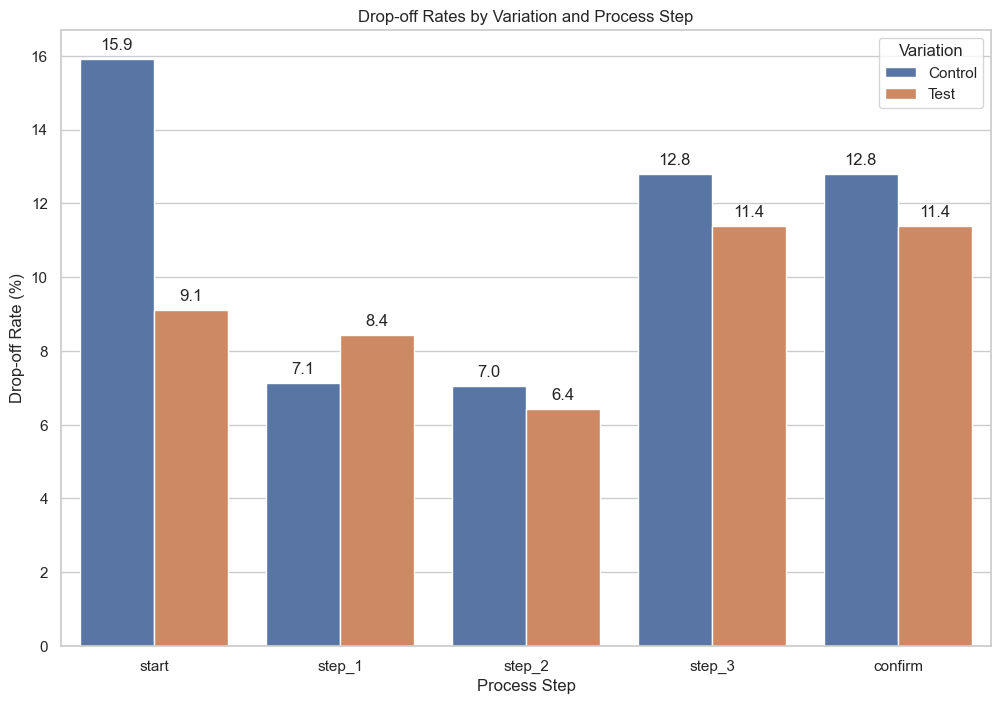

Z-Test Results for Drop-off Rates:
 {'step_1': {'z-stat': 20.596962138900018, 'p-value': 2.9220799203700115e-94}, 'step_2': {'z-stat': -37.19167068886712, 'p-value': 9.304526771805199e-303}, 'step_3': {'z-stat': -18.186659898125317, 'p-value': 6.583175186930141e-74}, 'start': {'z-stat': -8.353967659861256, 'p-value': 6.600742597391253e-17}, 'confirm': {'z-stat': 3.7114069973106436, 'p-value': 0.00020611039599606468}}


In [32]:
# Ensure the steps are ordered correctly
required_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_full['process_step'] = pd.Categorical(df_full['process_step'], categories=required_steps, ordered=True)

# Step 1: Calculate drop-off rates
# Count the number of unique clients reaching each step
step_counts = df_full.groupby(['variation', 'process_step'])['client_id'].nunique().reset_index()
step_counts_pivot = step_counts.pivot(index='variation', columns='process_step', values='client_id')

# Calculate the drop-off rate for each step
drop_off_rates = step_counts_pivot.diff(axis=1, periods=-1).div(step_counts_pivot, axis=0) * 100
drop_off_rates['confirm'] = (step_counts_pivot['step_3'] - step_counts_pivot['confirm']) / step_counts_pivot['step_3'] * 100

# Reshape drop_off_rates for plotting
drop_off_rates = drop_off_rates.reset_index().melt(id_vars=['variation'], value_name='drop_off_rate').dropna()

# Plot drop-off rates with labels
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=drop_off_rates, x='process_step', y='drop_off_rate', hue='variation', order=required_steps)
plt.title('Drop-off Rates by Variation and Process Step')
plt.xlabel('Process Step')
plt.ylabel('Drop-off Rate (%)')
plt.legend(title='Variation')

# Label the bars
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(format(height, '.1f'),
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center',
                     xytext=(0, 10),
                     textcoords='offset points')

plt.show()

# Perform Z-Test for Drop-Off Rates
interaction_counts = df_full.groupby(['variation', 'process_step'])['client_id'].count().unstack(fill_value=0)
drop_off_counts = interaction_counts.diff(axis=1).abs().iloc[:, 1:].fillna(0)
total_counts = interaction_counts.iloc[:, :-1]

# Ensure correct indexing by aligning the indexes
drop_off_counts = drop_off_counts.loc[:, drop_off_counts.columns.intersection(total_counts.columns)]

# Function to perform z-test for proportions
def z_test_proportion(success_a, size_a, success_b, size_b):
    count = np.array([success_a, success_b])
    nobs = np.array([size_a, size_b])
    stat, pval = proportions_ztest(count, nobs)
    return stat, pval

# Perform z-tests for each step
steps = drop_off_counts.columns
z_test_results = {}

for step in steps:
    try:
        success_a = drop_off_counts.loc['Control', step]
        size_a = total_counts.loc['Control', step]
        success_b = drop_off_counts.loc['Test', step]
        size_b = total_counts.loc['Test', step]
        
        # Perform z-test and handle cases where division by zero might occur
        if size_a > 0 and size_b > 0:
            stat, pval = z_test_proportion(success_a, size_a, success_b, size_b)
            z_test_results[step] = {'z-stat': stat, 'p-value': pval}
        else:
            z_test_results[step] = {'z-stat': np.nan, 'p-value': np.nan}
    except KeyError as e:
        print(f"KeyError for step {step}: {e}")
        z_test_results[step] = {'z-stat': np.nan, 'p-value': np.nan}

# Perform z-test for the "start" step by comparing initial counts to counts at "start"
initial_counts = df_full.groupby('variation')['client_id'].nunique()
start_counts = step_counts_pivot['start']
drop_off_start = initial_counts - start_counts

for variation in initial_counts.index:
    if initial_counts[variation] > 0:
        stat, pval = z_test_proportion(drop_off_start['Control'], initial_counts['Control'], drop_off_start['Test'], initial_counts['Test'])
        z_test_results['start'] = {'z-stat': stat, 'p-value': pval}
    else:
        z_test_results['start'] = {'z-stat': np.nan, 'p-value': np.nan}

# Perform z-test for the "confirm" step by comparing step_3 counts to confirm counts
step_3_counts = step_counts_pivot['step_3']
confirm_counts = step_counts_pivot['confirm']
drop_off_confirm = step_3_counts - confirm_counts

for variation in step_3_counts.index:
    if step_3_counts[variation] > 0:
        stat, pval = z_test_proportion(drop_off_confirm['Control'], step_3_counts['Control'], drop_off_confirm['Test'], step_3_counts['Test'])
        z_test_results['confirm'] = {'z-stat': stat, 'p-value': pval}
    else:
        z_test_results['confirm'] = {'z-stat': np.nan, 'p-value': np.nan}

print("Z-Test Results for Drop-off Rates:\n", z_test_results)

# Was the experiment run long enough?

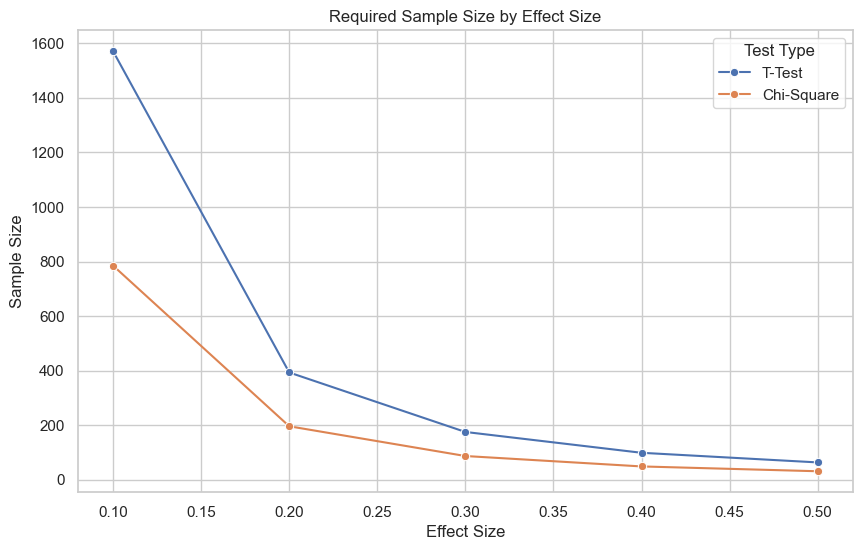

   Effect Size       T-Test  Chi-Square
0          0.1  1570.733066  784.886051
1          0.2   393.405699  196.221513
2          0.3   175.384672   87.209561
3          0.4    99.080327   49.055378
4          0.5    63.765612   31.395442


In [33]:
from statsmodels.stats.power import TTestIndPower, GofChisquarePower
import matplotlib.pyplot as plt
import seaborn as sns

# Define a range of effect sizes
effect_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]  # Small to large effect sizes

alpha = 0.05  # Significance level
power = 0.8  # Desired power

# Calculate required sample sizes for t-test and chi-square test for each effect size
t_test_sample_sizes = []
chi_square_sample_sizes = []

for effect_size in effect_sizes:
    t_test_analysis = TTestIndPower()
    t_test_sample_size = t_test_analysis.solve_power(effect_size, power=power, alpha=alpha, ratio=1)
    t_test_sample_sizes.append(t_test_sample_size)
    
    chi_square_analysis = GofChisquarePower()
    chi_square_sample_size = chi_square_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)
    chi_square_sample_sizes.append(chi_square_sample_size)

# Create a DataFrame for visualization
data = {
    'Effect Size': effect_sizes,
    'T-Test': t_test_sample_sizes,
    'Chi-Square': chi_square_sample_sizes
}

df_visualization = pd.DataFrame(data)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_visualization, x='Effect Size', y='T-Test', marker='o', label='T-Test')
sns.lineplot(data=df_visualization, x='Effect Size', y='Chi-Square', marker='o', label='Chi-Square')
plt.title('Required Sample Size by Effect Size')
plt.xlabel('Effect Size')
plt.ylabel('Sample Size')
plt.legend(title='Test Type')
plt.show()

# Print out the required sample sizes for review
print(df_visualization)

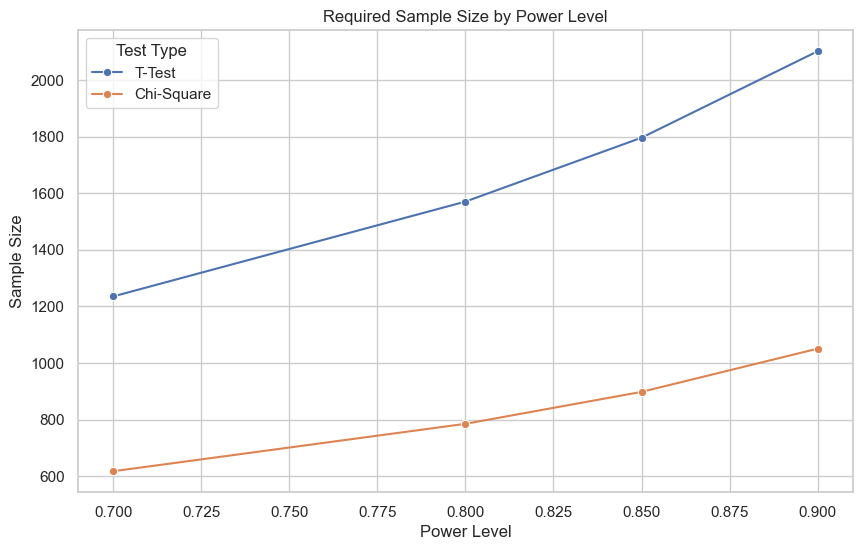

   Power Level       T-Test   Chi-Square
0         0.70  1235.361863   617.200398
1         0.80  1570.733066   784.886051
2         0.85  1796.638540   897.838797
3         0.90  2102.444767  1050.741941


In [34]:
from statsmodels.stats.power import TTestIndPower, GofChisquarePower
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define effect size and significance level
effect_size = 0.1  # Small effect size
alpha = 0.05  # Significance level

# Define a range of power levels
power_levels = [0.7, 0.8, 0.85, 0.9]

# Calculate required sample sizes for t-test and chi-square test for each power level
t_test_sample_sizes = []
chi_square_sample_sizes = []

for power in power_levels:
    t_test_analysis = TTestIndPower()
    t_test_sample_size = t_test_analysis.solve_power(effect_size, power=power, alpha=alpha, ratio=1)
    t_test_sample_sizes.append(t_test_sample_size)
    
    chi_square_analysis = GofChisquarePower()
    chi_square_sample_size = chi_square_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)
    chi_square_sample_sizes.append(chi_square_sample_size)

# Create a DataFrame for visualization
data = {
    'Power Level': power_levels,
    'T-Test': t_test_sample_sizes,
    'Chi-Square': chi_square_sample_sizes
}

df_visualization = pd.DataFrame(data)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_visualization, x='Power Level', y='T-Test', marker='o', label='T-Test')
sns.lineplot(data=df_visualization, x='Power Level', y='Chi-Square', marker='o', label='Chi-Square')
plt.title('Required Sample Size by Power Level')
plt.xlabel('Power Level')
plt.ylabel('Sample Size')
plt.legend(title='Test Type')
plt.show()

# Print out the required sample sizes for review
print(df_visualization)


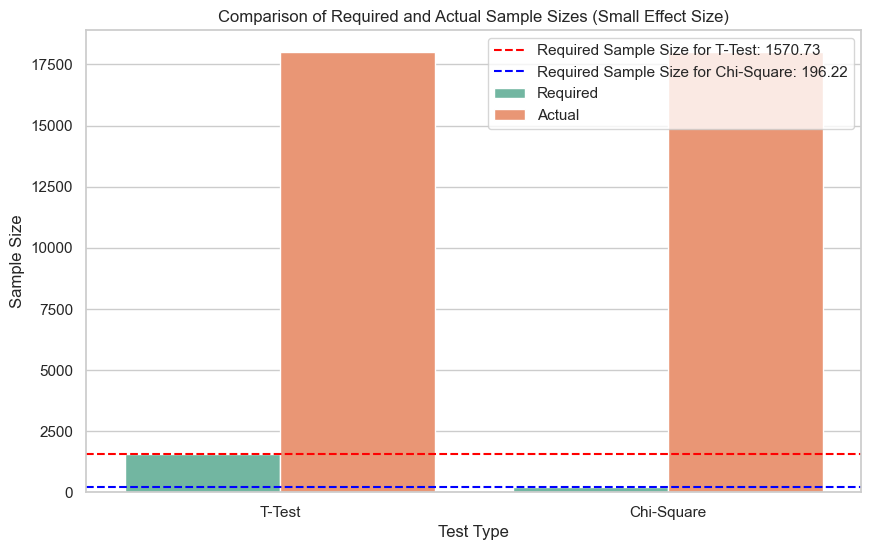

Required sample size for t-test: 1570.7330663315456
Required sample size for chi-square test: 196.221512735596
Actual sample size for control group: 18001
Actual sample size for test group: 21984
Actual sample size (minimum of both groups): 18001


In [35]:
from statsmodels.stats.power import TTestIndPower, GofChisquarePower
import matplotlib.pyplot as plt
import seaborn as sns

# Example for a t-test with a small effect size
effect_size_ttest = 0.1  # Small effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired power

analysis = TTestIndPower()
sample_size_ttest = analysis.solve_power(effect_size_ttest, power=power, alpha=alpha, ratio=1)

# Example for a chi-square test with a small effect size
effect_size_chi2 = 0.2  # Small effect size for chi-square
power_analysis = GofChisquarePower()
sample_size_chi2 = power_analysis.solve_power(effect_size=effect_size_chi2, alpha=alpha, power=power)

# Extracting actual sample sizes from the data
actual_sample_size_control = df_full[df_full['variation'] == 'Control']['client_id'].nunique()
actual_sample_size_test = df_full[df_full['variation'] == 'Test']['client_id'].nunique()
actual_sample_size = min(actual_sample_size_control, actual_sample_size_test)

# Create a DataFrame for visualization
data = {
    'Test': ['T-Test', 'Chi-Square', 'T-Test', 'Chi-Square'],
    'Type': ['Required', 'Required', 'Actual', 'Actual'],
    'Sample Size': [sample_size_ttest, sample_size_chi2, actual_sample_size, actual_sample_size]
}

df_visualization = pd.DataFrame(data)

# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Test', y='Sample Size', hue='Type', data=df_visualization, palette='Set2')
plt.title('Comparison of Required and Actual Sample Sizes (Small Effect Size)')
plt.xlabel('Test Type')
plt.ylabel('Sample Size')
plt.legend(title='Sample Size Type')
plt.axhline(sample_size_ttest, color='red', linestyle='--', label=f'Required Sample Size for T-Test: {sample_size_ttest:.2f}')
plt.axhline(sample_size_chi2, color='blue', linestyle='--', label=f'Required Sample Size for Chi-Square: {sample_size_chi2:.2f}')
plt.legend()
plt.show()

# Print out the required and actual sample sizes for review
print(f"Required sample size for t-test: {sample_size_ttest}")
print(f"Required sample size for chi-square test: {sample_size_chi2}")
print(f"Actual sample size for control group: {actual_sample_size_control}")
print(f"Actual sample size for test group: {actual_sample_size_test}")
print(f"Actual sample size (minimum of both groups): {actual_sample_size}")


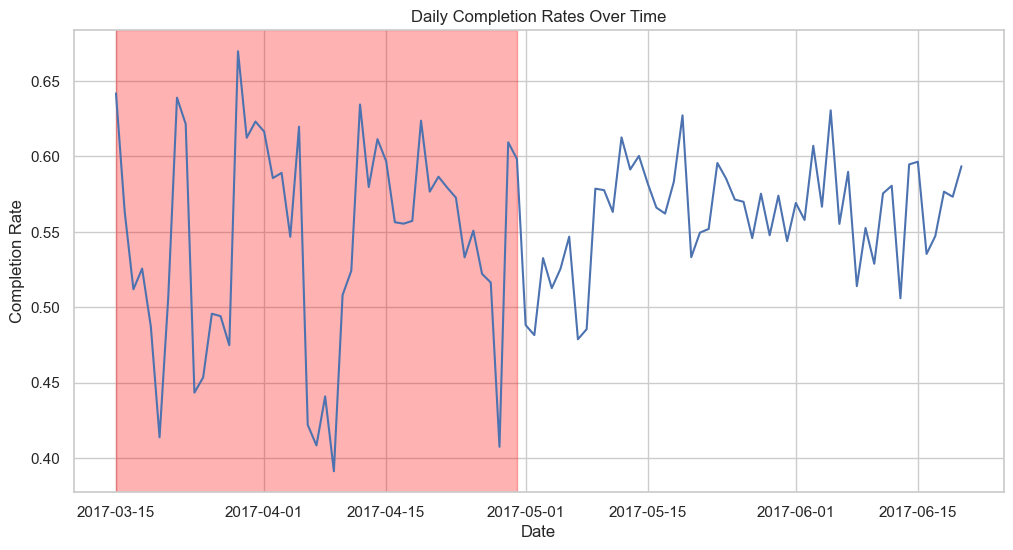

In [36]:
# Ensure 'date_time' is in datetime format
df_with_old_dates['date_time'] = pd.to_datetime(df_with_old_dates['date_time'])

# Extract the date part from 'date_time'
df_with_old_dates['date'] = df_with_old_dates['date_time'].dt.date

# Calculate daily completion rates
daily_completion_rates = df_with_old_dates[df_with_old_dates['process_step'] == 'confirm'].groupby('date')['client_id'].nunique() / df_with_old_dates.groupby('date')['client_id'].nunique()

# Plot daily completion rates
plt.figure(figsize=(12, 6))
daily_completion_rates.plot()

# Highlight the date range 3/15/2017 through 4/30/2017 in red
start_date = pd.to_datetime('2017-03-15').date()
end_date = pd.to_datetime('2017-04-30').date()
plt.axvspan(start_date, end_date, color='red', alpha=0.3)

plt.title('Daily Completion Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Completion Rate')
plt.show()

# Post April Analysis

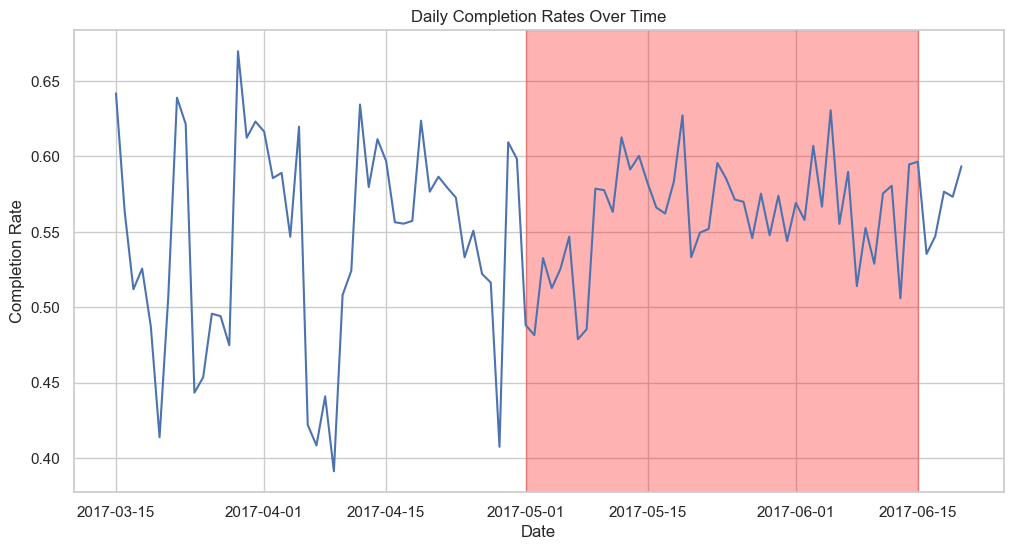

In [37]:
# Ensure 'date_time' is in datetime format
df_with_old_dates['date_time'] = pd.to_datetime(df_with_old_dates['date_time'])

# Extract the date part from 'date_time'
df_with_old_dates['date'] = df_with_old_dates['date_time'].dt.date

# Calculate daily completion rates
daily_completion_rates = df_with_old_dates[df_with_old_dates['process_step'] == 'confirm'].groupby('date')['client_id'].nunique() / df_with_old_dates.groupby('date')['client_id'].nunique()

# Plot daily completion rates
plt.figure(figsize=(12, 6))
daily_completion_rates.plot()

# Highlight the date range 3/15/2017 through 4/30/2017 in red
start_date = pd.to_datetime('2017-05-01').date()
end_date = pd.to_datetime('2017-06-15').date()
plt.axvspan(start_date, end_date, color='red', alpha=0.3)

plt.title('Daily Completion Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Completion Rate')
plt.show()

/Users/User/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/User/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


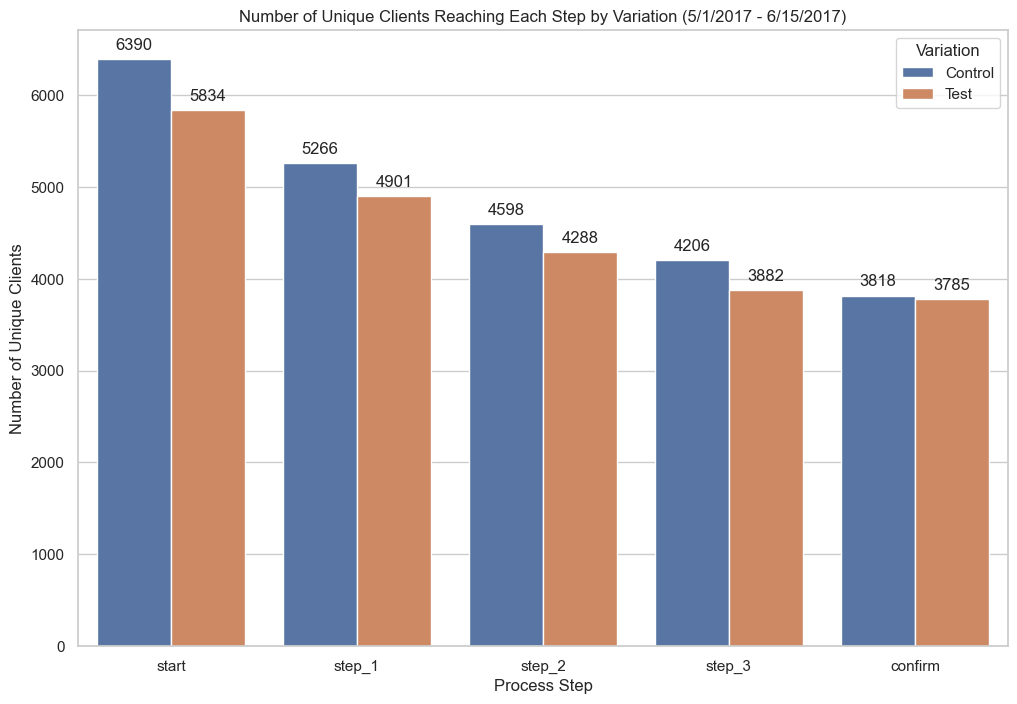

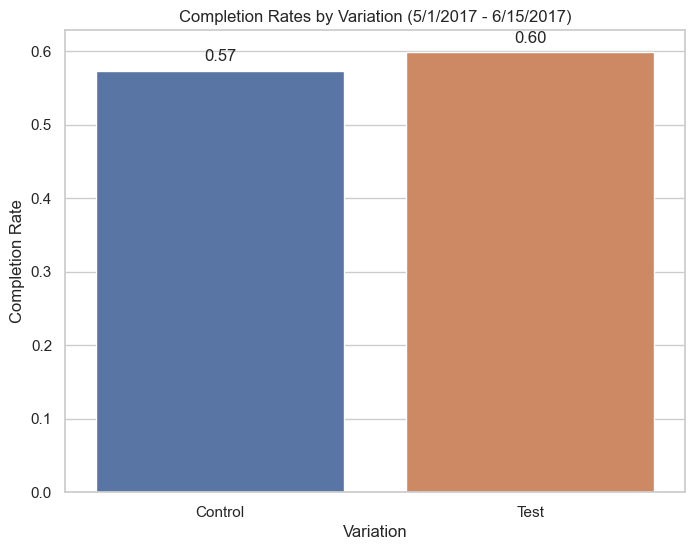

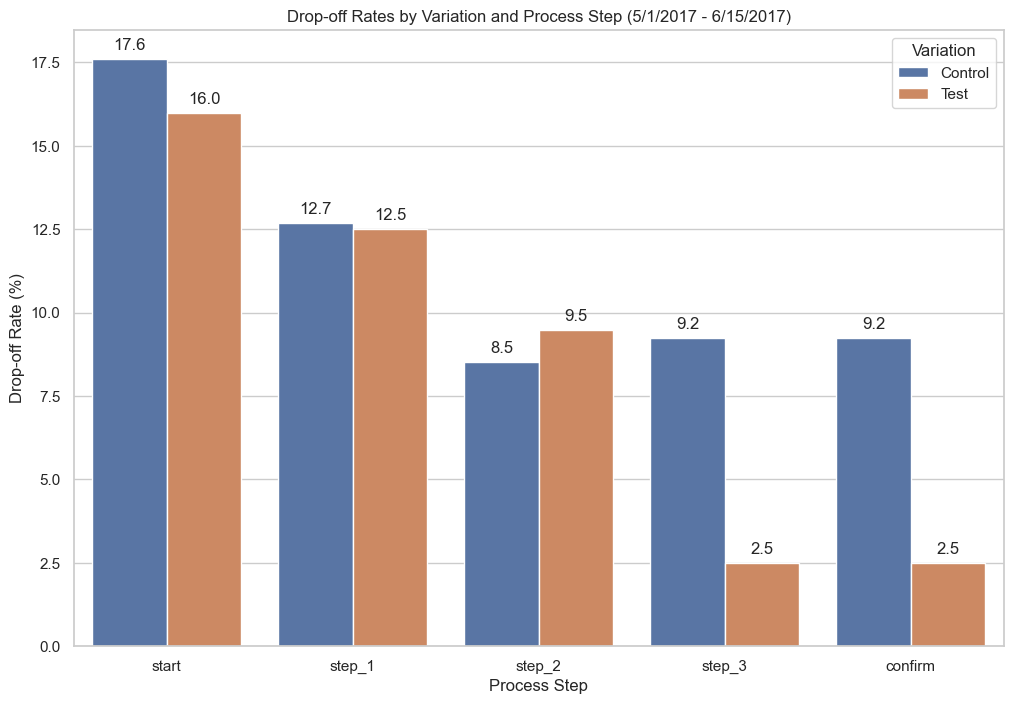

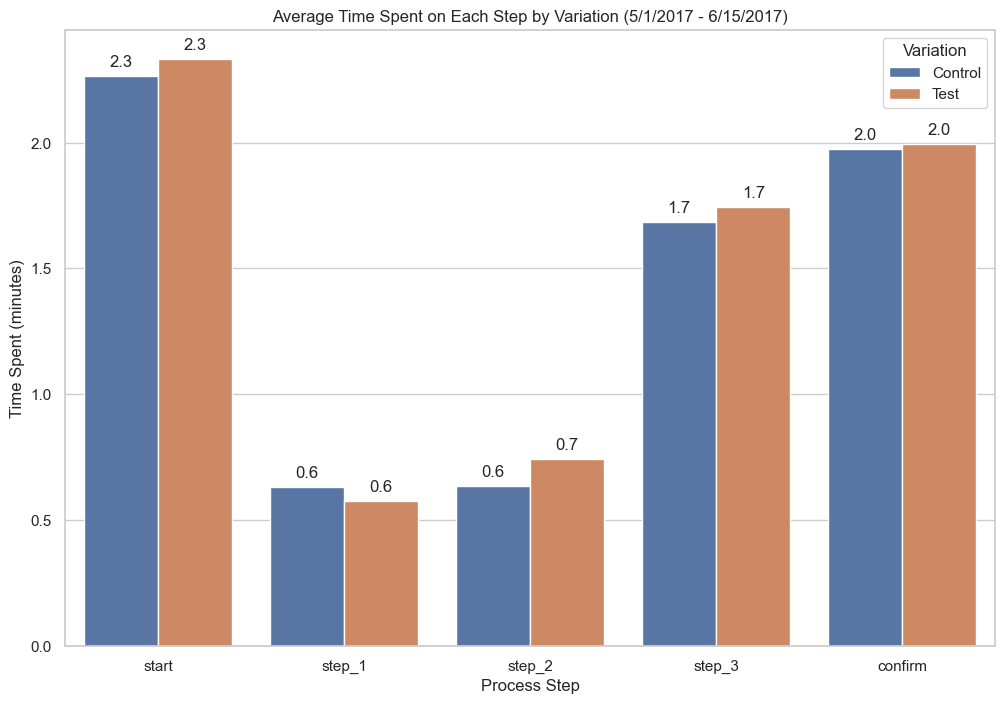

Chi-square test for completion rates: chi2 = 8.291242151583265, p-value = 0.003983672999670019
T-Test Results for Average Time Spent at Each Step (5/1/2017 - 6/15/2017):
 {'start': {'t-statistic': -0.42323131441351935, 'p-value': 0.6721354767084826}, 'step_1': {'t-statistic': 2.1959950981796648, 'p-value': 0.028108041664175427}, 'step_2': {'t-statistic': -3.5091907036826093, 'p-value': 0.0004513634987538234}, 'step_3': {'t-statistic': -1.2698294041756775, 'p-value': 0.20417687449260039}, 'confirm': {'t-statistic': -0.19239068918197078, 'p-value': 0.8474409939141786}}
Z-Test Results for Drop-off Rates:
 {'step_1': {'z-stat': 2.8940189611742055, 'p-value': 0.0038034519343747453}, 'step_2': {'z-stat': 0.3115856157175854, 'p-value': 0.7553554673903119}, 'step_3': {'z-stat': -1.715353613549357, 'p-value': 0.0862804144885186}, 'start': {'z-stat': -9.033206845814478, 'p-value': 1.6671315228054283e-19}, 'confirm': {'z-stat': 12.728865334041528, 'p-value': 4.087358816172692e-37}}


In [38]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# Ensure 'date_time' is in datetime format
df_with_old_dates['date_time'] = pd.to_datetime(df_with_old_dates['date_time'])

# Filter df_full for dates between 5/1/2017 and 6/15/2017
df_experiment_period = df_with_old_dates[(df_with_old_dates['date_time'] >= '2017-05-01') & (df_with_old_dates['date_time'] <= '2017-06-15')]

# Ensure the steps are ordered correctly
required_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
df_experiment_period['process_step'] = pd.Categorical(df_experiment_period['process_step'], categories=required_steps, ordered=True)

# Calculate interaction counts
interaction_counts_period = df_experiment_period.groupby(['variation', 'process_step'])['client_id'].nunique().reset_index()

# Calculate completion rates
completion_counts_period = df_experiment_period[df_experiment_period['process_step'] == 'confirm'].groupby('variation')['client_id'].nunique()
total_clients_period = df_experiment_period.groupby('variation')['client_id'].nunique()
completion_rates_period = (completion_counts_period / total_clients_period).reset_index()
completion_rates_period.columns = ['variation', 'completion_rate']

# Calculate drop-off rates
step_counts_period = df_experiment_period.groupby(['variation', 'process_step'])['client_id'].nunique().reset_index()
step_counts_pivot_period = step_counts_period.pivot(index='variation', columns='process_step', values='client_id')

drop_off_rates_period = step_counts_pivot_period.diff(axis=1, periods=-1).div(step_counts_pivot_period, axis=0) * 100
drop_off_rates_period['confirm'] = (step_counts_pivot_period['step_3'] - step_counts_pivot_period['confirm']) / step_counts_pivot_period['step_3'] * 100
drop_off_rates_period = drop_off_rates_period.reset_index().melt(id_vars=['variation'], value_name='drop_off_rate').dropna()

# Calculate total time spent on each step
df_experiment_period = df_experiment_period.sort_values(by=['client_id', 'visit_id', 'date_time'])
df_experiment_period['time_diff'] = df_experiment_period.groupby(['client_id', 'visit_id', 'variation'])['date_time'].diff()

# Remove entries with no time_diff (NaN)
df_time_spent_period = df_experiment_period.dropna(subset=['time_diff'])
df_time_spent_period['time_diff_minutes'] = df_time_spent_period['time_diff'].dt.total_seconds() / 60

# Aggregate total time spent on each step
time_spent_period = df_time_spent_period.groupby(['variation', 'process_step'])['time_diff_minutes'].mean().reset_index()

# Plot interaction counts
plt.figure(figsize=(12, 8))
barplot_interactions = sns.barplot(data=interaction_counts_period, x='process_step', y='client_id', hue='variation', order=required_steps)
plt.title('Number of Unique Clients Reaching Each Step by Variation (5/1/2017 - 6/15/2017)')
plt.xlabel('Process Step')
plt.ylabel('Number of Unique Clients')
plt.legend(title='Variation')
for p in barplot_interactions.patches:
    height = p.get_height()
    barplot_interactions.annotate(format(height, '.0f'),
                                  (p.get_x() + p.get_width() / 2., height),
                                  ha='center', va='center',
                                  xytext=(0, 10),
                                  textcoords='offset points')
plt.show()

# Plot completion rates
plt.figure(figsize=(8, 6))
barplot_completion = sns.barplot(data=completion_rates_period, x='variation', y='completion_rate')
plt.title('Completion Rates by Variation (5/1/2017 - 6/15/2017)')
plt.xlabel('Variation')
plt.ylabel('Completion Rate')
for p in barplot_completion.patches:
    height = p.get_height()
    barplot_completion.annotate(format(height, '.2f'),
                                (p.get_x() + p.get_width() / 2., height),
                                ha='center', va='center',
                                xytext=(0, 10),
                                textcoords='offset points')
plt.show()

# Plot drop-off rates
plt.figure(figsize=(12, 8))
barplot_dropoff = sns.barplot(data=drop_off_rates_period, x='process_step', y='drop_off_rate', hue='variation', order=required_steps)
plt.title('Drop-off Rates by Variation and Process Step (5/1/2017 - 6/15/2017)')
plt.xlabel('Process Step')
plt.ylabel('Drop-off Rate (%)')
plt.legend(title='Variation')
for p in barplot_dropoff.patches:
    height = p.get_height()
    barplot_dropoff.annotate(format(height, '.1f'),
                             (p.get_x() + p.get_width() / 2., height),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')
plt.show()

# Plot total time spent on each step
plt.figure(figsize=(12, 8))
barplot_time = sns.barplot(data=time_spent_period, x='process_step', y='time_diff_minutes', hue='variation', order=required_steps)
plt.title('Average Time Spent on Each Step by Variation (5/1/2017 - 6/15/2017)')
plt.xlabel('Process Step')
plt.ylabel('Time Spent (minutes)')
plt.legend(title='Variation')
for p in barplot_time.patches:
    height = p.get_height()
    barplot_time.annotate(format(height, '.1f'),
                          (p.get_x() + p.get_width() / 2., height),
                          ha='center', va='center',
                          xytext=(0, 10),
                          textcoords='offset points')
plt.show()

# Statistical Tests
# Chi-Square Test for Completion Rates
completion_counts = df_experiment_period[df_experiment_period['process_step'] == 'confirm'].groupby('variation')['client_id'].nunique().values
total_counts = df_experiment_period.groupby('variation')['client_id'].nunique().values

contingency_table = np.array([completion_counts, total_counts - completion_counts]).T
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test for completion rates: chi2 = {chi2}, p-value = {p}")

# T-Tests for Average Time Spent at Each Step
t_test_results_period = {}
for step in required_steps:
    control_times = df_time_spent_period[(df_time_spent_period['variation'] == 'Control') & (df_time_spent_period['process_step'] == step)]['time_diff_minutes']
    test_times = df_time_spent_period[(df_time_spent_period['variation'] == 'Test') & (df_time_spent_period['process_step'] == step)]['time_diff_minutes']
    t_stat, p_val = ttest_ind(control_times, test_times, equal_var=False, nan_policy='omit')
    t_test_results_period[step] = {'t-statistic': t_stat, 'p-value': p_val}

print("T-Test Results for Average Time Spent at Each Step (5/1/2017 - 6/15/2017):\n", t_test_results_period)

# Z-Test for Drop-Off Rates
z_test_results = {}

# Function to perform z-test for proportions
def z_test_proportion(success_a, size_a, success_b, size_b):
    count = np.array([success_a, success_b])
    nobs = np.array([size_a, size_b])
    stat, pval = proportions_ztest(count, nobs)
    return stat, pval

# Calculate drop-off counts
drop_off_counts = step_counts_pivot_period.diff(axis=1).abs().iloc[:, 1:].fillna(0)
total_counts = step_counts_pivot_period.iloc[:, :-1]

# Ensure correct indexing by aligning the indexes
drop_off_counts = drop_off_counts.loc[:, drop_off_counts.columns.intersection(total_counts.columns)]

# Perform z-tests for each step
steps = drop_off_counts.columns

for step in steps:
    try:
        success_a = drop_off_counts.loc['Control', step]
        size_a = total_counts.loc['Control', step]
        success_b = drop_off_counts.loc['Test', step]
        size_b = total_counts.loc['Test', step]
        
        # Perform z-test and handle cases where division by zero might occur
        if size_a > 0 and size_b > 0:
            stat, pval = z_test_proportion(success_a, size_a, success_b, size_b)
            z_test_results[step] = {'z-stat': stat, 'p-value': pval}
        else:
            z_test_results[step] = {'z-stat': np.nan, 'p-value': np.nan}
    except KeyError as e:
        print(f"KeyError for step {step}: {e}")
        z_test_results[step] = {'z-stat': np.nan, 'p-value': np.nan}

# Perform z-test for the "start" step by comparing initial counts to counts at "start"
initial_counts = df_experiment_period.groupby('variation')['client_id'].nunique()
start_counts = step_counts_pivot_period['start']
drop_off_start = initial_counts - start_counts

for variation in initial_counts.index:
    if initial_counts[variation] > 0:
        stat, pval = z_test_proportion(drop_off_start['Control'], initial_counts['Control'], drop_off_start['Test'], initial_counts['Test'])
        z_test_results['start'] = {'z-stat': stat, 'p-value': pval}
    else:
        z_test_results['start'] = {'z-stat': np.nan, 'p-value': np.nan}

# Perform z-test for the "confirm" step by comparing step_3 counts to confirm counts
step_3_counts = step_counts_pivot_period['step_3']
confirm_counts = step_counts_pivot_period['confirm']
drop_off_confirm = step_3_counts - confirm_counts

for variation in step_3_counts.index:
    if step_3_counts[variation] > 0:
        stat, pval = z_test_proportion(drop_off_confirm['Control'], step_3_counts['Control'], drop_off_confirm['Test'], step_3_counts['Test'])
        z_test_results['confirm'] = {'z-stat': stat, 'p-value': pval}
    else:
        z_test_results['confirm'] = {'z-stat': np.nan, 'p-value': np.nan}

print("Z-Test Results for Drop-off Rates:\n", z_test_results)

# What other data may be required and/or helpful to the analysis?

<b> Other Considerations </b>

* Bevarioral: 
    - Page Views: The number of page views during the process. Are users clicking around and having difficulty navigating certain pages?
    - Session Duration: Are users making multiple visits prior to starting the process? is the process difficult to start?
    
* Interaction Data:
    - Customer Support: Number of and type of interactions with customer support. When does this typically occur in the user journey?

* Client Segmentation Data:
    - Acquisition channel: Did the customer begin their journey through email outreach? social media? direct from advisor?
    
* Process-rated Data:
    - Did users attempt to read FAQs or help-guides?
    - Did a user specify why they stopped the process (follow up survey?)
    - Bounce Rate - Is there a common stopping point where users tend to give up?

* UX Metrics
    - Scroll Depth: Are users finding themselves scrolling far down the page? Could this be indicative of them being unable to find what they need?
    

In [39]:
df_visits = df_with_old_dates

# Ensure 'date_time' is in datetime format
df_visits['date_time'] = pd.to_datetime(df_visits['date_time'])

# Sort the data by visitor_id and date_time
df_visits = df_visits.sort_values(by=['visitor_id', 'date_time'])

# Filter data to get the first occurrence of each visitor_id starting the process ('start')
first_start = df_visits[df_visits['process_step'] == 'start'].drop_duplicates(subset=['visitor_id'], keep='first')

# Count the number of visit_id for each visitor_id prior to the 'start' step
visitor_visit_counts = df_visits.groupby('visitor_id')['visit_id'].nunique().reset_index()
visitor_visit_counts.columns = ['visitor_id', 'visit_count']

# Merge with first_start to get the visit counts for visitors starting the process
visitor_start_visits = pd.merge(first_start, visitor_visit_counts, on='visitor_id', how='left')

# Calculate the average number of visits prior to starting the process
average_visits_prior_to_start = visitor_start_visits['visit_count'].mean()
average_visits_prior_to_start

1.2397558505110564

Average number of visits prior to starting the process: 1.2397558505110564


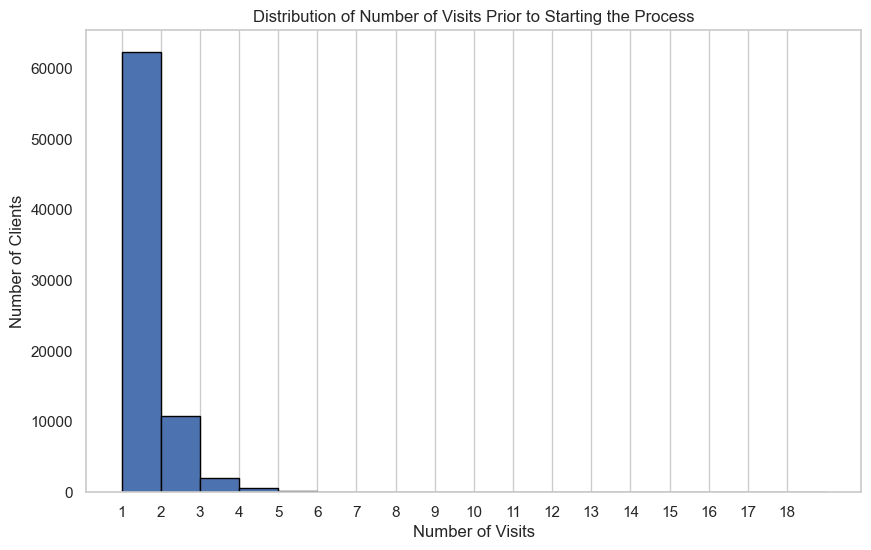

In [40]:
# Read in the data
df_visits = df_with_old_dates

# Ensure 'date_time' is in datetime format
df_visits['date_time'] = pd.to_datetime(df_visits['date_time'])

# Sort the data by visitor_id and date_time
df_visits = df_visits.sort_values(by=['visitor_id', 'date_time'])

# Filter data to get the first occurrence of each visitor_id starting the process ('start')
first_start = df_visits[df_visits['process_step'] == 'start'].drop_duplicates(subset=['visitor_id'], keep='first')

# Count the number of visit_id for each visitor_id prior to the 'start' step
visitor_visit_counts = df_visits.groupby('visitor_id')['visit_id'].nunique().reset_index()
visitor_visit_counts.columns = ['visitor_id', 'visit_count']

# Merge with first_start to get the visit counts for visitors starting the process
visitor_start_visits = pd.merge(first_start, visitor_visit_counts, on='visitor_id', how='left')

# Calculate the average number of visits prior to starting the process
average_visits_prior_to_start = visitor_start_visits['visit_count'].mean()
print(f"Average number of visits prior to starting the process: {average_visits_prior_to_start}")

# Plot the distribution of the number of visits prior to starting the process
plt.figure(figsize=(10, 6))
plt.hist(visitor_start_visits['visit_count'], bins=range(1, visitor_start_visits['visit_count'].max() + 2), edgecolor='black')
plt.title('Distribution of Number of Visits Prior to Starting the Process')
plt.xlabel('Number of Visits')
plt.ylabel('Number of Clients')
plt.xticks(range(1, visitor_start_visits['visit_count'].max() + 1))
plt.grid(axis='y')
plt.show()